# Linear & Non Linear Regression Notebook

Notebook to experiment solely with Linear Regression Models

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from __future__ import print_function
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import sklearn as sk
from sklearn.linear_model import LinearRegression

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
master = pd.read_parquet('master.parquet',engine='fastparquet')

In [ ]:
master = master.select_dtypes(include=['float64','int64'])

In [ ]:
master=master.fillna(0)

In [ ]:
X = master.drop('price_y', axis = 1)

In [ ]:
y = master['price_y']

Using Stats Models to do Regression - Provides more info than SKlearn in the summary:

In [ ]:
X2 = sm.add_constant(X)
X2 = X2.drop(columns=['listing_id','id','scrape_id','host_id','longitude', 'latitude', 'zipcode','has_availability','license'])

In [ ]:
est = sm.OLS(y, X2)
est2 = est.fit()

Plotting the Price vs Square Feet

In [ ]:
from statsmodels.graphics.regressionplots import plot_fit

In [ ]:
mod = sm.OLS(y.head(10000),X2['bedrooms'].head(10000))
results = mod.fit()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sm.graphics.plot_fit(results, 0, ax=ax)
ax.set_ylabel("Price")
ax.set_xlabel("Bedrooms")
ax.set_title("Linear Regression")
plt.show()

In [ ]:
est2.summary()

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

Based on the above summary, we would eliminate only the following columns: host_listings_count, host_total_listings_count, beds, neighbourhood_group_cleansed. So we would keep columns in the following list:

In [ ]:
manually_excluded = ['listing_id','id','scrape_id','host_id','longitude', 'latitude', 'zipcode','has_availability','license']
exclude = ['host_listings_count', 'host_total_listings_count', 'beds', 'neighbourhood_group_cleansed']
include = [i for i in X.columns if i not in exclude]
final = [i for i in include if i not in manually_excluded]

In [ ]:
for i in X[final]:
    print i

Analysis of Residuals

Jarque-Bera test:

In [ ]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(est2.resid)
lzip(name, test)

Omni test:

In [ ]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(est2.resid)
lzip(name, test)

In [ ]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
fig = plot_leverage_resid2(results, ax = ax)
plt.show()

In [ ]:
type(est2)

Multicollinearity

In [ ]:
np.linalg.cond(est2.model.exog)

Heteroskedasticity

It is customary to check for heteroscedasticity of residuals once you build the linear regression model. The reason is, we want to check if the model thus built is unable to explain some pattern in the response variable Y, that eventually shows up in the residuals. This would result in an inefficient and unstable regression model that could yield bizarre predictions later on.

For these test the null hypothesis is that all observations have the same error variance, i.e. errors are homoscedastic. The tests differ in which kind of heteroscedasticity is considered as alternative hypothesis. They also vary in the power of the test for different types of heteroscedasticity.

Breush-Pagan test: It tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroskedasticity is present.
If the test statistic has a p-value below an appropriate threshold (e.g. p<0.05) then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.

In [ ]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breushpagan(est2.resid, est2.model.exog)
lzip(name, test)

Goldfeld-Quandt test

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(est2.resid, est2.model.exog)
lzip(name, test)

In [ ]:
from statsmodels.graphics.regressionplots import plot_regress_exog

Plot regression results against one regressor.

This plots four graphs in a 2 by 2 figure: ‘endog versus exog’, ‘residuals versus exog’, ‘fitted versus exog’ and ‘fitted plus residual versus exog’

In [ ]:
fig = plt.figure(figsize=(12,12))
plot_regress_exog(est2, 5, fig=fig)

In [ ]:
cols_for_plot = ['accommodates','number_of_reviews','review_scores_rating','transit_variety','transitTextWordsPerc']

In [ ]:
#plot_regress_exog(est2, 'number_of_reviews')

In [ ]:
#plot_regress_exog(est2, 'review_scores_rating')

In [ ]:
#plot_regress_exog(est2, 'transit_variety')

In [ ]:
#plot_regress_exog(est2, 'transitTextWordsPerc')

Component-Component plus Residual (CCPR) Plots
The CCPR plot provides a way to judge the effect of one regressor on the 
response variable by taking into account the effects of the other 
independent variables. The partial residuals plot is defined as 
Residuals+BiXi    versus  Xi . The component adds  BiXi  versus 
Xi  to show where the fitted line would lie. Care should be taken if  Xi  
is highly correlated with any of the other independent variables. If this 
is the case, the variance evident in the plot will be an underestimate of 
the true variance.

Conclusion: the variables that have low variance in the top right graph and low slope on the bottom right plot are showing less heteroskedasticity (better for autoregression analysis). However, the heteroskedasticity tests show that there is a lot of heteroskedasticity, which implies a poor future prediction (Standard estimation methods are inefficient when the errors are heteroscedastic or have non-constant variance)

Linearity: Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct:

The basic idea of the Rainbow test is that even if the true relationship is non-linear, a good linear fit can be achieved on a subsample in the "middle" of the data. The null hypothesis is rejected whenever the overall fit is significantly worse than the fit for the subsample.

In [ ]:
"""name = ['t value', 'p value']
test = sms.linear_harvey_collier(est2)
lzip(name, test)"""

Heteroskedastic-Robust Standard Errors

In [ ]:
results2_robust = est2.get_robustcov_results()

In [ ]:
results2_robust.summary()

The same linear regression in SKLearn

In [ ]:
lm = LinearRegression()

In [ ]:
lm.fit(X,master['price_y'])

In [ ]:
print 'Estimated intercept coefficient: ', lm.intercept_

In [ ]:
print 'Number of coefficients: ', len(lm.coef_)

Regression coefficients represent the mean change in the response variable for one unit of change in the predictor variable while holding other predictors in the model constant. This statistical control that regression provides is important because it isolates the role of one variable from all of the others in the model.

The key to understanding the coefficients is to think of them as slopes, and they’re often called slope coefficients. I’ll illustrate this in the fitted line plot below, where I’ll use a person’s height to model their weight.

In [ ]:
pd.DataFrame(zip(X.columns, lm.coef_), columns=['Features','Estimated Coefficients'])

In [ ]:
plt.scatter(master.transitTextWordsPerc, master.price_y)
plt.xlabel("Percentage of Words in Transit Description Field")
plt.ylabel("Calendar Price")
plt.title("Plotting Price and Transit Text Words Perc")
plt.show()


In [ ]:
lm.predict(X)[0:390]


#Problem: we have many calendar days for the same listings. For each listing, one price prediction is made but because
#we have many calendar days for each listing, the above outputs the same result for each cal day
#Make better representation

More Regressions

In [ ]:
from sklearn import linear_model

Lasso Lars Regression

In [ ]:
ll = linear_model.LassoLars(alpha=.1)
ll.fit(X, y)

In [ ]:
ll.coef_

In [ ]:
ll.intercept_

Bayesian Ridge Regression

In [ ]:
br = linear_model.BayesianRidge()

In [ ]:
br.fit(X,y)

In [ ]:
br.coef_

In [ ]:
br.intercept_

Stochastic Gradient Descent

In [ ]:
X_trunc = X.head(10000)

In [ ]:
y_trunc = y.head(10000)

In [ ]:
sgd = linear_model.SGDClassifier()
sgd.fit(X_trunc, y_trunc)

In [ ]:
sgd.coef_

In [ ]:
sgd.intercept_

Non Linear Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)

Plynomial Interpolation

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

In [ ]:
def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)

In [ ]:
len(y)

In [ ]:
X_trunc = X_trunc.head(1000)
y_trunc = y_trunc.head(1000)

In [ ]:
#X = x[:, np.newaxis]
#X_plot = x_plot[:, np.newaxis]
x_plot = np.linspace(0, 1, len(X_trunc))
x = np.linspace(0, 1, len(X_trunc))

colors = ['teal', 'yellowgreen']

lw = 2

plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw)

plt.scatter(x, y_trunc, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([2, 3]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X_trunc, y_trunc)
    y_plot = model.predict(X_trunc)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

More Nonlinear Regressions (These will freeze)

In [ ]:
"""poly = PolynomialFeatures(degree=3)
poly.fit_transform(X)"""

In [ ]:
"""poly = PolynomialFeatures(degree=4)
poly.fit_transform(X)"""

Outputting list of features that are deemed to be statistically significant by this process

In [ ]:
for i in pd.DataFrame(zip(X.columns, lm.coef_), columns=['features','estimatedCoefficients']):
    print i

New Regressions 4/10/18

Going to take the average price for each listing time series and just use that to do a regression.
List of ideas/topics: 

linear and polynomial muultivariate regressions, 
imputation methods, feature scaling, feature standrdization, 
one hot encoding, 
OLS vs SGD for optimization, 
correlation matrices, 
creation of new variables, 
performance metrics and model comparisons, 
interaction between variables, 
multicollinearity, 
how to encode lat-long in regression,
potentially apply PCA,
text driven feature engineering,
produce 3 models: one for weekdays, one for weekends, one for holidays. then make ensemble

Preparing the dataset first: taking the avg of each listing price time series

In [2]:
cal = pd.read_csv('Datasources/inside_airbnb/calendar.csv')

In [3]:
cal.columns

Index([u'listing_id', u'date', u'available', u'price'], dtype='object')

In [4]:
cal.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [5]:
cal = cal.infer_objects()

In [6]:
cal['price'] = cal['price'].astype(str).map(lambda x: x.lstrip('$'))
cal['price'] = cal['price'].apply(pd.to_numeric, errors='coerce')
cal['price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [7]:
cal['date'] = pd.to_datetime(cal['date'])
cal['month'] = cal['date'].apply(lambda x: x.month)
cal['day'] = cal['date'].apply(lambda x: x.day)

In [8]:
cal['day_of_week'] = cal['date'].dt.weekday_name

In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [10]:
cl = calendar()
holidays = cl.holidays(start=cal['date'].min(), end=cal['date'].max())

In [11]:
cal['holiday'] = cal['date'].isin(holidays)

In [12]:
cal.head(5)

,listing_id,date,available,price,month,day,day_of_week,holiday
0,11204286,2017-07-05,t,49.0,7,5,Wednesday,False
1,11204286,2017-07-04,t,49.0,7,4,Tuesday,True
2,11204286,2017-07-03,t,49.0,7,3,Monday,False
3,11204286,2017-07-02,t,49.0,7,2,Sunday,False
4,11204286,2017-07-01,t,49.0,7,1,Saturday,False


In [13]:
cal.date.min()

Timestamp('2016-07-06 00:00:00')

In [14]:
cal = cal[(cal['date']>'2016-07-06')&(cal['date']<'2016-10-06')]

In [15]:
c = cal.loc[cal.available!='f']
c = c[['listing_id','date','price','month','day_of_week','holiday']]

In [16]:
len(c)

288684

In [17]:
c.isnull().sum()

listing_id        0
date              0
price          7517
month             0
day_of_week       0
holiday           0
dtype: int64

In [18]:
c=c.fillna(c.mean())

In [19]:
len(cal['listing_id'].unique())

6608

In [20]:
c_hol = c[c['holiday']==True]
c_wke = c[(c['holiday']==False)&((c['day_of_week']=='Sunday')|(c['day_of_week']=='Saturday'))]
c_wkd = c[(~c.isin(c_hol['date']))&(~c.isin(c_wke['date']))]

In [21]:
mean_price_hol = c_hol.groupby(by='listing_id')['price'].mean()
mean_price_wke = c_wke.groupby(by='listing_id')['price'].mean()
mean_price_wkd = c_wkd.groupby(by='listing_id')['price'].mean()

In [22]:
mean_price_hol = pd.DataFrame(mean_price_hol)
mean_price_wke = pd.DataFrame(mean_price_wke)
mean_price_wkd = pd.DataFrame(mean_price_wkd)

In [23]:
mean_price_hol = mean_price_hol.reset_index()
mean_price_wke = mean_price_wke.reset_index()
mean_price_wkd = mean_price_wkd.reset_index()

In [24]:
listings = pd.read_csv('Datasources/inside_airbnb/listings.csv')

Creating Master and Parsing Object Columns with Regex

In [25]:
master_hol = listings.merge(mean_price_hol, how='inner', left_on='id', right_on='listing_id')
master_wke = listings.merge(mean_price_wke, how='inner', left_on='id', right_on='listing_id')
master_wkd = listings.merge(mean_price_wkd, how='inner', left_on='id', right_on='listing_id')

In [26]:
master_hol['host_response_rate'] = master_hol['host_response_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_hol['host_response_rate'] = master_hol['host_response_rate'].apply(pd.to_numeric, errors='coerce')
master_hol['host_response_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['host_acceptance_rate'] = master_hol['host_acceptance_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_hol['host_acceptance_rate'] = master_hol['host_acceptance_rate'].apply(pd.to_numeric, errors='coerce')
master_hol['host_acceptance_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['extra_people'] = master_hol['extra_people'].astype(str).map(lambda x: x.lstrip('$'))
master_hol['extra_people'] = master_hol['extra_people'].apply(pd.to_numeric, errors='coerce')
master_hol['extra_people'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['weekly_price'] = master_hol['weekly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_hol['weekly_price'] = master_hol['weekly_price'].apply(pd.to_numeric, errors='coerce')
master_hol['weekly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['monthly_price'] = master_hol['monthly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_hol['monthly_price'] = master_hol['monthly_price'].apply(pd.to_numeric, errors='coerce')
master_hol['monthly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['security_deposit'] = master_hol['security_deposit'].astype(str).map(lambda x: x.lstrip('$'))
master_hol['security_deposit'] = master_hol['security_deposit'].apply(pd.to_numeric, errors='coerce')
master_hol['security_deposit'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_hol['cleaning_fee'] = master_hol['cleaning_fee'].astype(str).map(lambda x: x.lstrip('$'))
master_hol['cleaning_fee'] = master_hol['cleaning_fee'].apply(pd.to_numeric, errors='coerce')
master_hol['cleaning_fee'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [27]:
master_wke['host_response_rate'] = master_wke['host_response_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_wke['host_response_rate'] = master_wke['host_response_rate'].apply(pd.to_numeric, errors='coerce')
master_wke['host_response_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['host_acceptance_rate'] = master_wke['host_acceptance_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_wke['host_acceptance_rate'] = master_wke['host_acceptance_rate'].apply(pd.to_numeric, errors='coerce')
master_wke['host_acceptance_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['extra_people'] = master_wke['extra_people'].astype(str).map(lambda x: x.lstrip('$'))
master_wke['extra_people'] = master_wke['extra_people'].apply(pd.to_numeric, errors='coerce')
master_wke['extra_people'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['weekly_price'] = master_wke['weekly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_wke['weekly_price'] = master_wke['weekly_price'].apply(pd.to_numeric, errors='coerce')
master_wke['weekly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['monthly_price'] = master_wke['monthly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_wke['monthly_price'] = master_wke['monthly_price'].apply(pd.to_numeric, errors='coerce')
master_wke['monthly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['security_deposit'] = master_wke['security_deposit'].astype(str).map(lambda x: x.lstrip('$'))
master_wke['security_deposit'] = master_wke['security_deposit'].apply(pd.to_numeric, errors='coerce')
master_wke['security_deposit'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wke['cleaning_fee'] = master_wke['cleaning_fee'].astype(str).map(lambda x: x.lstrip('$'))
master_wke['cleaning_fee'] = master_wke['cleaning_fee'].apply(pd.to_numeric, errors='coerce')
master_wke['cleaning_fee'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [28]:
master_wkd['host_response_rate'] = master_wkd['host_response_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_wkd['host_response_rate'] = master_wkd['host_response_rate'].apply(pd.to_numeric, errors='coerce')
master_wkd['host_response_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['host_acceptance_rate'] = master_wkd['host_acceptance_rate'].astype(str).map(lambda x: x.rstrip("%"))
master_wkd['host_acceptance_rate'] = master_wkd['host_acceptance_rate'].apply(pd.to_numeric, errors='coerce')
master_wkd['host_acceptance_rate'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['extra_people'] = master_wkd['extra_people'].astype(str).map(lambda x: x.lstrip('$'))
master_wkd['extra_people'] = master_wkd['extra_people'].apply(pd.to_numeric, errors='coerce')
master_wkd['extra_people'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['weekly_price'] = master_wkd['weekly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_wkd['weekly_price'] = master_wkd['weekly_price'].apply(pd.to_numeric, errors='coerce')
master_wkd['weekly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['monthly_price'] = master_wkd['monthly_price'].astype(str).map(lambda x: x.lstrip('$'))
master_wkd['monthly_price'] = master_wkd['monthly_price'].apply(pd.to_numeric, errors='coerce')
master_wkd['monthly_price'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['security_deposit'] = master_wkd['security_deposit'].astype(str).map(lambda x: x.lstrip('$'))
master_wkd['security_deposit'] = master_wkd['security_deposit'].apply(pd.to_numeric, errors='coerce')
master_wkd['security_deposit'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
master_wkd['cleaning_fee'] = master_wkd['cleaning_fee'].astype(str).map(lambda x: x.lstrip('$'))
master_wkd['cleaning_fee'] = master_wkd['cleaning_fee'].apply(pd.to_numeric, errors='coerce')
master_wkd['cleaning_fee'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

Now with master we have a price_x which is the original base price provided by the listing host, and the price_y which is the mean price for each listing we calculated above

In [29]:
target_hol = master_hol['price_y']
target_wke = master_wke['price_y']
target_wkd = master_wkd['price_y']

In [30]:
master_hol = master_hol.drop(columns='price_y')
master_wke = master_wke.drop(columns='price_y')
master_wkd = master_wkd.drop(columns='price_y')

In [31]:
master_hol['ones'] = np.ones(len(master_hol))
master_wke['ones'] = np.ones(len(master_wke))
master_wkd['ones'] = np.ones(len(master_wkd))

Multivariate linear regression

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [33]:
X_hol = master_hol.select_dtypes(include=['float64', 'int64'])
X_wke = master_wke.select_dtypes(include=['float64', 'int64'])
X_wkd = master_wkd.select_dtypes(include=['float64', 'int64'])

In [34]:
X_hol.isnull().sum()

id                                   0
scrape_id                            0
host_id                              0
host_response_rate                 215
host_acceptance_rate               348
host_listings_count                  0
host_total_listings_count            0
neighbourhood_group_cleansed      4000
zipcode                             61
latitude                             0
longitude                            0
accommodates                         0
bathrooms                            9
bedrooms                             2
beds                                 3
square_feet                       3926
weekly_price                      3262
monthly_price                     3932
security_deposit                  1978
cleaning_fee                       842
guests_included                      0
extra_people                         0
minimum_nights                       0
maximum_nights                       0
has_availability                  4000
availability_30          

In [35]:
#Dropping columns with too many null values

In [36]:
X_hol = X_hol.drop(columns=['neighbourhood_group_cleansed','square_feet','has_availability','license','weekly_price','monthly_price'])
X_wke = X_wke.drop(columns=['neighbourhood_group_cleansed','square_feet','has_availability','license','weekly_price','monthly_price'])
X_wkd = X_wkd.drop(columns=['neighbourhood_group_cleansed','square_feet','has_availability','license','weekly_price','monthly_price'])

In [37]:
#replacing nulls in columns remaining if have nulls
X_hol = X_hol.fillna(value=X_hol.mean())
X_wke = X_wke.fillna(value=X_wke.mean())
X_wkd = X_wkd.fillna(value=X_wkd.mean())

Feature Engineering and Column Removal

In [38]:
#First removing columns that should always be removed:
X_hol = X_hol.drop(columns=['id','listing_id','host_id','scrape_id'])
X_wke = X_wke.drop(columns=['id','listing_id','host_id','scrape_id'])
X_wkd = X_wkd.drop(columns=['id','listing_id','host_id','scrape_id'])

First Models

In [39]:
linear_regression_hol = sm.OLS(target_hol,X_hol)
linear_regression_wke = sm.OLS(target_wke,X_wke)
linear_regression_wkd = sm.OLS(target_wkd,X_wkd)

In [40]:
fitted_model_hol = linear_regression_hol.fit()
fitted_model_wke = linear_regression_wke.fit()
fitted_model_wkd = linear_regression_wkd.fit()

In [41]:
fitted_model_hol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     151.6
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:20:19   Log-Likelihood:                -24571.
No. Observations:                4000   AIC:                         4.920e+04
Df Residuals:                    3969   BIC:                         4.940e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_response_rate                -0.8415      0.145     -5.802      0.000      -1.126      -0.557
host_acceptance_rate               0.2428      0.100      2.436      0.015       0.047       0.438
host_listings_count                0.0431      0.017      2.595      0.009       0.011       0.076
host_total_listings_count          0.0431      0.017      2.592      0.010       0.010       0.076
zipcode                            0.0010      0.002      0.600      0.548      -0.002       0.004
latitude                         -87.5903     30.108     -2.909      0.004    -146.619     -28.562
longitude                       -416.2294     33.303    -12.498      0.000    -481.523    -350.936
accommodates                      22.5214      1.406     16.015      0.000      19.764      25.279
bathrooms                         -2.0309      3.230     -0.629      0.530      -8.363       4.301
bedrooms                          29.5554      3.330      8.877      0.000      23.028      36.083
beds                              -2.1191      2.021     -1.049      0.294      -6.081       1.843
security_deposit                   0.0860      0.016      5.538      0.000       0.056       0.116
cleaning_fee                       0.1342      0.034      3.987      0.000       0.068       0.200
guests_included                   -0.8771      1.205     -0.728      0.467      -3.239       1.485
extra_people                      -0.0155      0.086     -0.180      0.857      -0.184       0.153
minimum_nights                    -0.6658      0.296     -2.252      0.024      -1.245      -0.086
maximum_nights                   6.97e-06      0.000      0.062      0.951      -0.000       0.000
availability_30                    0.8224      0.427      1.925      0.054      -0.015       1.660
availability_60                    1.9181      0.464      4.138      0.000       1.009       2.827
availability_90                   -1.8969      0.339     -5.589      0.000      -2.562      -1.231
availability_365                   0.0336      0.018      1.913      0.056      -0.001       0.068
number_of_reviews                 -0.1730      0.072     -2.389      0.017      -0.315      -0.031
review_scores_rating               0.1494      0.507      0.295      0.768      -0.845       1.144
review_scores_accuracy             7.4406      3.841      1.937      0.053      -0.089      14.971
review_scores_cleanliness          8.4160      3.392      2.481      0.013       1.766      15.066
review_scores_checkin             -6.0322      4.837     -1.247      0.212     -15.516       3.451
review_scores_communication        2.7302      4.620      0.591      0.555      -6.328      11.789
review_scores_location             6.1712      3.582      1.723      0.085      -0.852      13.195
review_scores_

In [42]:
fitted_model_wke.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     250.2
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:20:20   Log-Likelihood:                -34494.
No. Observations:                5656   AIC:                         6.905e+04
Df Residuals:                    5625   BIC:                         6.926e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_response_rate                -0.4421      0.119     -3.709      0.000      -0.676      -0.208
host_acceptance_rate               0.1720      0.081      2.128      0.033       0.014       0.330
host_listings_count                0.0530      0.015      3.615      0.000       0.024       0.082
host_total_listings_count          0.0530      0.015      3.612      0.000       0.024       0.082
zipcode                            0.0011      0.002      0.737      0.461      -0.002       0.004
latitude                        -172.4805     24.520     -7.034      0.000    -220.548    -124.413
longitude                       -395.5945     26.790    -14.766      0.000    -448.114    -343.075
accommodates                      25.8170      1.173     22.008      0.000      23.517      28.117
bathrooms                          4.7778      2.694      1.773      0.076      -0.504      10.059
bedrooms                          25.6923      2.687      9.562      0.000      20.425      30.959
beds                              -6.5307      1.660     -3.934      0.000      -9.785      -3.276
security_deposit                   0.1040      0.013      8.299      0.000       0.079       0.129
cleaning_fee                       0.1532      0.027      5.626      0.000       0.100       0.207
guests_included                    0.5731      0.988      0.580      0.562      -1.364       2.510
extra_people                       0.0733      0.070      1.052      0.293      -0.063       0.210
minimum_nights                    -0.7225      0.266     -2.721      0.007      -1.243      -0.202
maximum_nights                 -9.587e-06      0.000     -0.089      0.929      -0.000       0.000
availability_30                    1.8061      0.334      5.405      0.000       1.151       2.461
availability_60                    1.2353      0.311      3.968      0.000       0.625       1.846
availability_90                   -1.3797      0.175     -7.903      0.000      -1.722      -1.037
availability_365                  -0.0048      0.014     -0.345      0.730      -0.032       0.022
number_of_reviews                 -0.1944      0.056     -3.475      0.001      -0.304      -0.085
review_scores_rating               0.1830      0.416      0.440      0.660      -0.633       0.999
review_scores_accuracy             8.4169      3.183      2.644      0.008       2.176      14.657
review_scores_cleanliness         11.0489      2.748      4.020      0.000       5.661      16.437
review_scores_checkin             -5.7586      3.987     -1.444      0.149     -13.575       2.058
review_scores_communication        1.0196      3.858      0.264      0.792      -6.544       8.584
review_scores_location             8.8979      2.969      2.996      0.003       3.077      14.719
review_scores_

In [43]:
fitted_model_wkd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                price_y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     259.6
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        00:20:20   Log-Likelihood:                -34972.
No. Observations:                5753   AIC:                         7.001e+04
Df Residuals:                    5722   BIC:                         7.021e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
host_response_rate                -0.4215      0.116     -3.630      0.000      -0.649      -0.194
host_acceptance_rate               0.1671      0.079      2.125      0.034       0.013       0.321
host_listings_count                0.0369      0.014      2.570      0.010       0.009       0.065
host_total_listings_count          0.0369      0.014      2.570      0.010       0.009       0.065
zipcode                            0.0010      0.002      0.658      0.510      -0.002       0.004
latitude                        -170.1208     23.923     -7.111      0.000    -217.019    -123.222
longitude                       -387.3736     26.071    -14.858      0.000    -438.483    -336.264
accommodates                      24.7553      1.139     21.727      0.000      22.522      26.989
bathrooms                          6.9120      2.625      2.633      0.008       1.766      12.058
bedrooms                          24.7327      2.608      9.484      0.000      19.620      29.845
beds                              -6.6073      1.607     -4.111      0.000      -9.758      -3.456
security_deposit                   0.1000      0.012      8.209      0.000       0.076       0.124
cleaning_fee                       0.1849      0.027      6.957      0.000       0.133       0.237
guests_included                    0.5910      0.962      0.614      0.539      -1.295       2.477
extra_people                       0.0507      0.068      0.744      0.457      -0.083       0.184
minimum_nights                    -0.6489      0.258     -2.516      0.012      -1.154      -0.143
maximum_nights                 -7.674e-06      0.000     -0.073      0.942      -0.000       0.000
availability_30                    1.7898      0.327      5.468      0.000       1.148       2.431
availability_60                    1.1069      0.305      3.633      0.000       0.510       1.704
availability_90                   -1.2791      0.170     -7.542      0.000      -1.612      -0.947
availability_365                  -0.0107      0.014     -0.791      0.429      -0.037       0.016
number_of_reviews                 -0.2038      0.054     -3.756      0.000      -0.310      -0.097
review_scores_rating               0.1070      0.406      0.264      0.792      -0.689       0.903
review_scores_accuracy             9.5858      3.096      3.096      0.002       3.517      15.655
review_scores_cleanliness          9.6464      2.653      3.636      0.000       4.446      14.847
review_scores_checkin             -4.8223      3.864     -1.248      0.212     -12.398       2.753
review_scores_communication        1.9437      3.758      0.517      0.605      -5.423       9.311
review_scores_location             7.1964      2.863      2.514      0.012       1.584      12.809
review_scores_

In [44]:
fitted_model_hol.predict(X_hol).head(3)

0    69.734608
1    60.878695
2    80.387699
dtype: float64

In [45]:
target_hol.head(3)

0     49.0
1     59.0
2    120.0
Name: price_y, dtype: float64

In [46]:
fitted_model_wke.predict(X_hol).head(3)

0    97.785381
1    83.074072
2    79.316160
dtype: float64

In [47]:
target_wke.head(3)

0     49.0
1     59.0
2    120.0
Name: price_y, dtype: float64

In [48]:
fitted_model_wkd.predict(X_hol).head(3)

0    95.150725
1    80.800950
2    76.057899
dtype: float64

In [49]:
target_wkd.head(3)

0     49.0
1     59.0
2    120.0
Name: price_y, dtype: float64

In [50]:
mean_expected_value_hol = target_hol.mean()
mean_expected_value_wke = target_wke.mean()
mean_expected_value_wkd = target_wkd.mean()

In [51]:
Squared_errors_hol = pd.Series(mean_expected_value_hol - target_hol)**2
Squared_errors_wke = pd.Series(mean_expected_value_wke - target_wke)**2
Squared_errors_wkd = pd.Series(mean_expected_value_wkd - target_wkd)**2

In [52]:
SSE_hol = sum(Squared_errors_hol)
SSE_wke = sum(Squared_errors_wke)
SSE_wkd = sum(Squared_errors_wkd)

In [53]:
print(SSE_hol)
print(SSE_wke)
print(SSE_wkd)

108784533.417
153256485.028
151583477.248


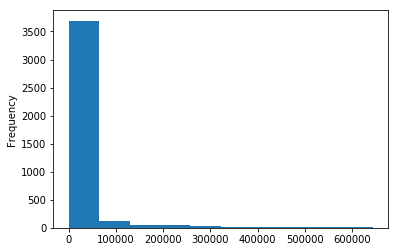

In [54]:
Squared_errors_hol.plot('hist')
plt.show()

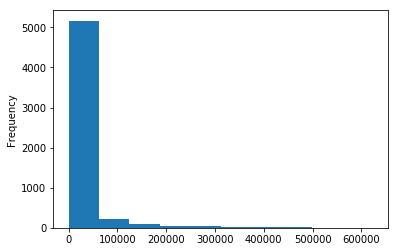

In [55]:
Squared_errors_wke.plot('hist')
plt.show()

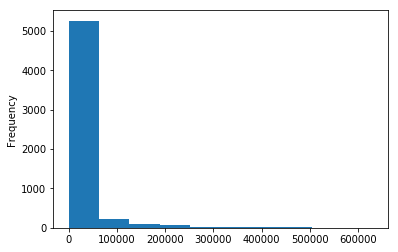

In [56]:
Squared_errors_wkd.plot('hist')
plt.show()

In [57]:
X_hol_corr = pd.DataFrame(X_hol.corr()).fillna(1)
X_wke_corr = pd.DataFrame(X_wke.corr()).fillna(1)
X_wkd_corr = pd.DataFrame(X_wkd.corr()).fillna(1)

In [58]:
import seaborn as sb

In [59]:
%matplotlib inline

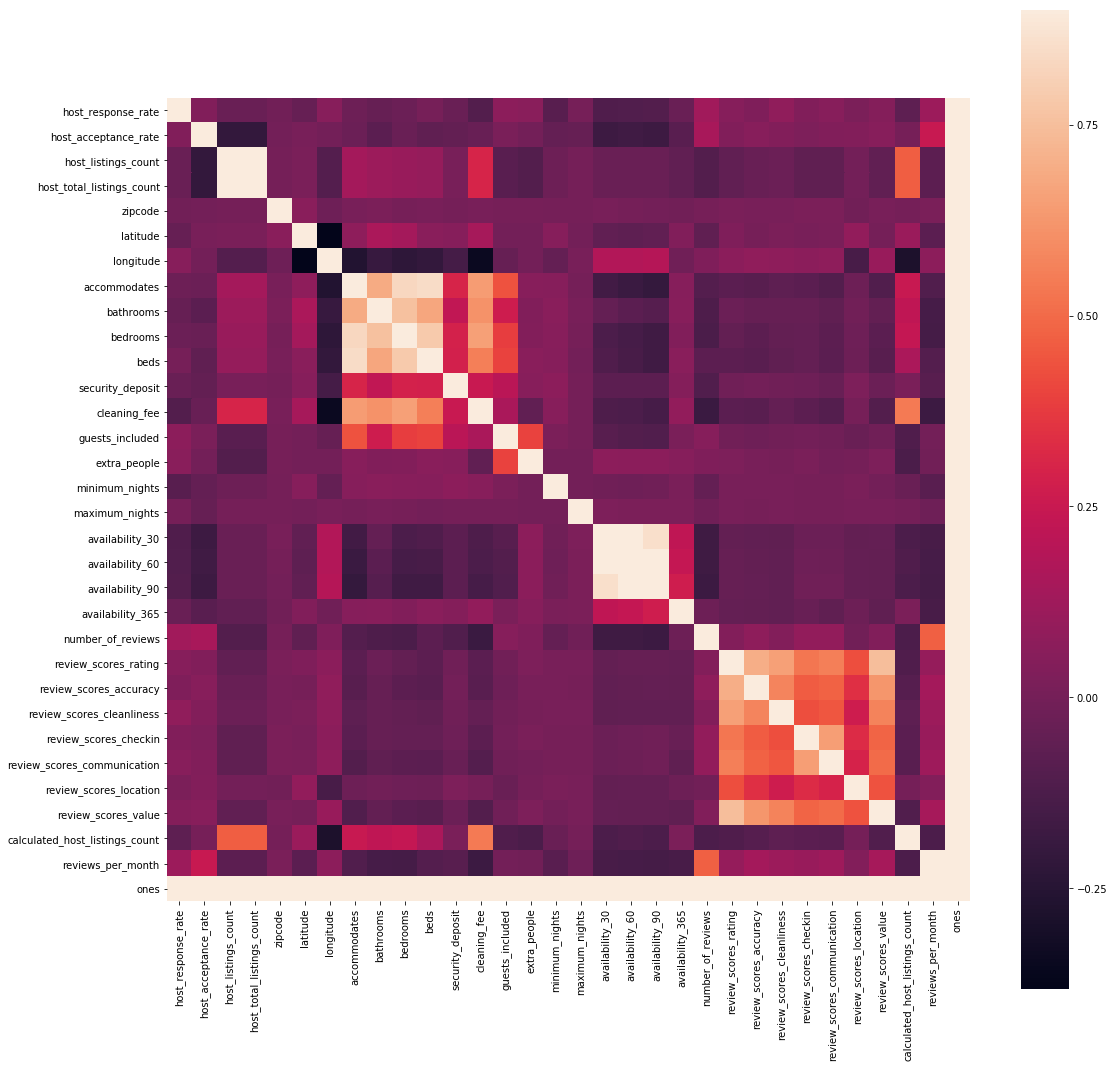

In [60]:
f, ax = plt.subplots(figsize=(18,18))
sb.heatmap(X_hol_corr, vmax=.9, square=True)

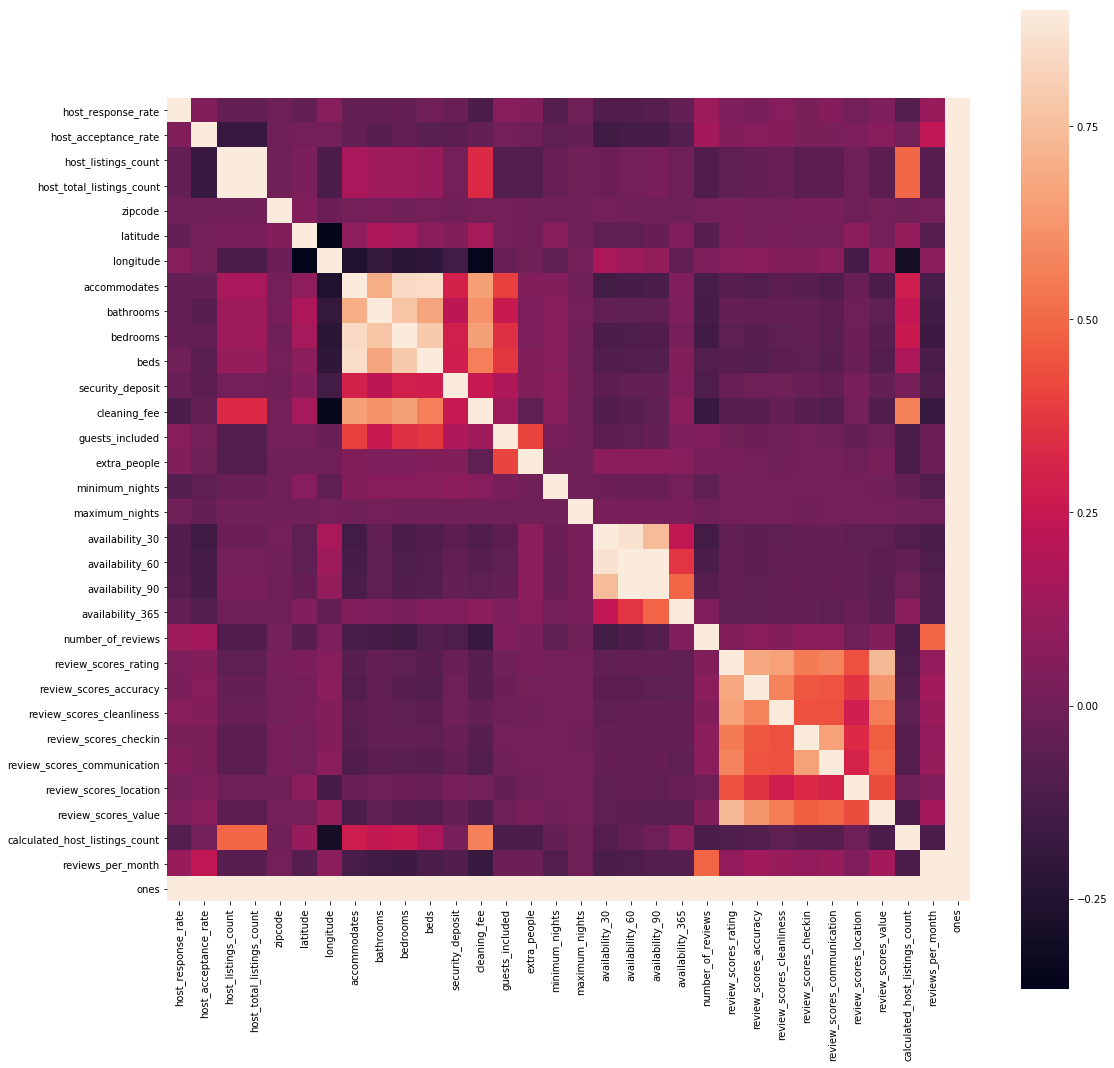

In [61]:
f, ax = plt.subplots(figsize=(18,18))
sb.heatmap(X_wke_corr, vmax=.9, square=True)

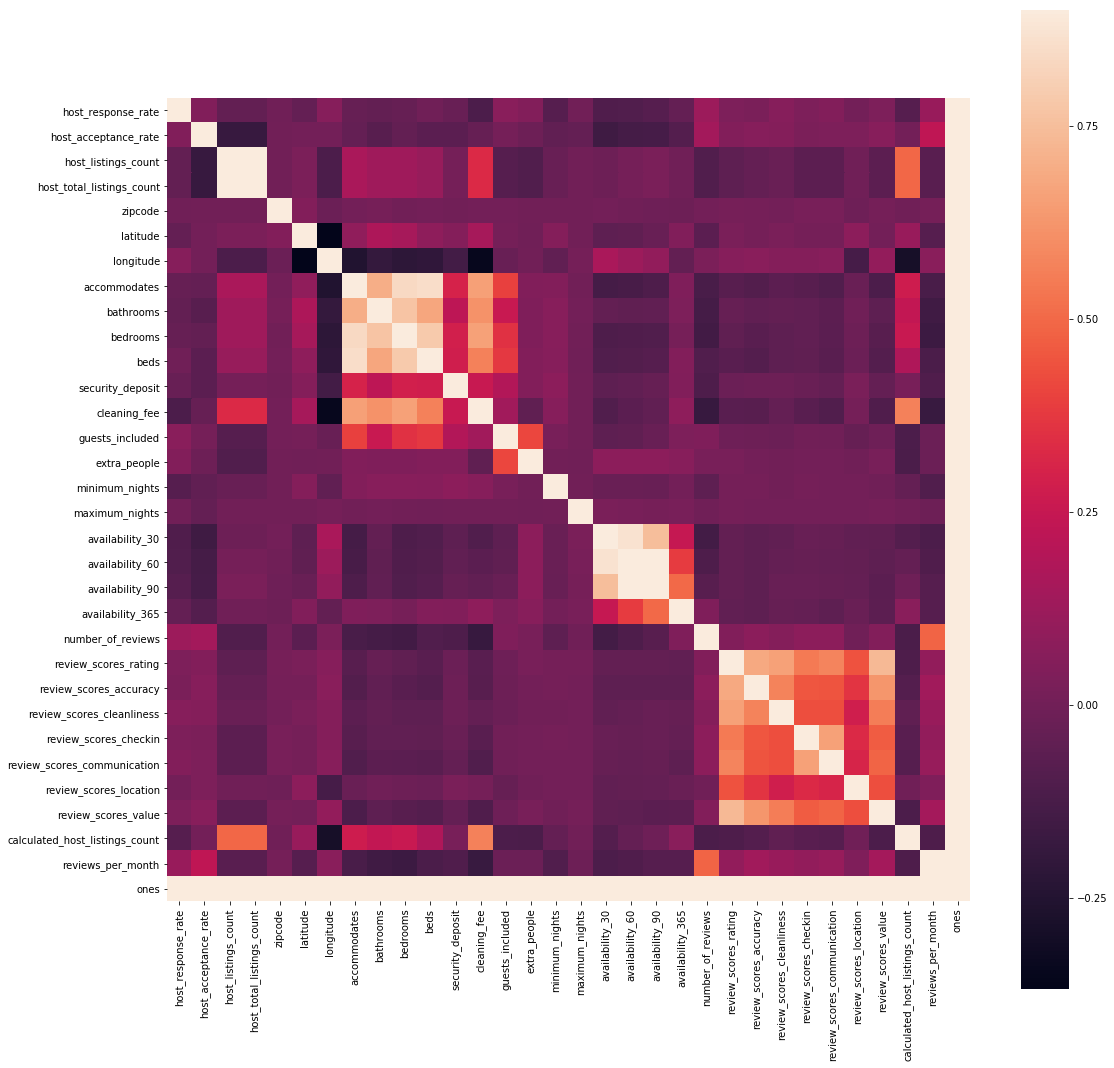

In [62]:
f, ax = plt.subplots(figsize=(18,18))
sb.heatmap(X_wkd_corr, vmax=.9, square=True)

Eigenvector Analysis

In [63]:
eigenvalues_hol, eigenvectors_hol = np.linalg.eig(X_hol_corr)
eigenvalues_wke, eigenvectors_wke = np.linalg.eig(X_wke_corr)
eigenvalues_wkd, eigenvectors_wkd = np.linalg.eig(X_wkd_corr)

In [64]:
list(eigenvalues_hol)

[7.4394224240473514,
 -4.0962256053123633,
 4.9623495270022051,
 3.5834013827702154,
 2.4424114628189075,
 2.1363479207920215,
 1.4199595743046924,
 1.1996485308739802,
 1.0994019406237392,
 1.022071098837515,
 1.0010158549275725,
 0.94215325042920839,
 0.92946838897605855,
 0.87865408699848879,
 0.86658308594135502,
 0.77304854150674251,
 0.76069372512830091,
 0.66610480962385454,
 0.030992848764688073,
 0.55958782097314697,
 0.1303416495579329,
 0.14945055990646849,
 0.17961652623800137,
 0.22222891564447833,
 0.26662253152329457,
 0.49431480156977775,
 0.46911226647154358,
 0.42569075025655784,
 0.33335007433059033,
 0.34609483458181861,
 0.36608641989187435,
 3.8172177889435461e-17]

In [65]:
eigenvectors_hol

array([[ -9.89112434e-02,  -1.44851406e-01,   5.57867525e-02, ...,
          3.17763055e-02,   1.00074860e-02,  -1.19444323e-16],
       [ -8.74633925e-02,  -1.58373081e-01,   6.37941060e-02, ...,
          1.89427966e-02,  -3.72339504e-02,  -3.52447087e-16],
       [ -1.29281928e-01,  -1.23160229e-01,  -1.30189802e-01, ...,
          8.72660055e-03,  -1.89101826e-02,   7.07106781e-01],
       ..., 
       [ -1.29244369e-01,  -1.35007861e-01,  -1.83593089e-01, ...,
          7.37261265e-03,  -7.15239932e-03,   7.06146902e-16],
       [ -9.34095321e-02,  -1.43020068e-01,   1.35790289e-01, ...,
         -5.25464062e-03,   6.05351714e-02,   2.57012767e-16],
       [ -6.38623695e-01,   7.30812056e-01,   5.77616038e-02, ...,
         -3.51003565e-03,   3.15560892e-03,   2.31980044e-18]])

Now using SGD

In [66]:
#WIP

In [67]:
#First, scale and standardize data

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
st = StandardScaler()

In [71]:
#Xst = st.fit_transform(X)

Feature Importance for Holidays

In [72]:
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [73]:
linear_regression_hol = linear_model.LinearRegression(normalize=False, fit_intercept=True)
standardization = StandardScaler()
Stand_coef_linear_reg = make_pipeline(standardization, linear_regression_hol)
linear_regression_hol.fit(X_hol,target_hol)
for coef, var in sorted(zip(map(abs, linear_regression_hol.coef_), X_hol.columns[:-1]),reverse=True):
    print ("%6.3f %s" % (coef,var))

416.229 longitude
87.590 latitude
29.555 bedrooms
22.521 accommodates
 9.065 review_scores_value
 8.416 review_scores_cleanliness
 7.441 review_scores_accuracy
 6.171 review_scores_location
 6.032 review_scores_checkin
 4.259 reviews_per_month
 2.730 review_scores_communication
 2.119 beds
 2.031 bathrooms
 1.918 availability_60
 1.897 availability_90
 0.877 guests_included
 0.841 host_response_rate
 0.822 availability_30
 0.666 minimum_nights
 0.321 calculated_host_listings_count
 0.243 host_acceptance_rate
 0.173 number_of_reviews
 0.149 review_scores_rating
 0.134 cleaning_fee
 0.086 security_deposit
 0.043 host_total_listings_count
 0.043 host_listings_count
 0.034 availability_365
 0.015 extra_people
 0.001 zipcode
 0.000 maximum_nights


Feature Importance for Weekends

In [74]:
linear_regression_wke = linear_model.LinearRegression(normalize=False, fit_intercept=True)
standardization = StandardScaler()
Stand_coef_linear_reg_wke = make_pipeline(standardization, linear_regression_wke)
linear_regression_wke.fit(X_wke,target_wke)
for coef, var in sorted(zip(map(abs, linear_regression_wke.coef_), X_wke.columns[:-1]),reverse=True):
    print ("%6.3f %s" % (coef,var))

395.594 longitude
172.481 latitude
25.817 accommodates
25.692 bedrooms
12.213 review_scores_value
11.049 review_scores_cleanliness
 8.898 review_scores_location
 8.417 review_scores_accuracy
 6.531 beds
 5.759 review_scores_checkin
 4.778 bathrooms
 4.528 reviews_per_month
 1.806 availability_30
 1.380 availability_90
 1.235 availability_60
 1.020 review_scores_communication
 0.722 minimum_nights
 0.573 guests_included
 0.442 host_response_rate
 0.356 calculated_host_listings_count
 0.194 number_of_reviews
 0.183 review_scores_rating
 0.172 host_acceptance_rate
 0.153 cleaning_fee
 0.104 security_deposit
 0.073 extra_people
 0.053 host_total_listings_count
 0.053 host_listings_count
 0.005 availability_365
 0.001 zipcode
 0.000 maximum_nights


Feature Importance for Weekdays

In [75]:
linear_regression_wkd = linear_model.LinearRegression(normalize=False, fit_intercept=True)
standardization = StandardScaler()
Stand_coef_linear_reg_wkd = make_pipeline(standardization, linear_regression_hol)
linear_regression_wkd.fit(X_wkd,target_wkd)
for coef, var in sorted(zip(map(abs, linear_regression_wkd.coef_), X_wkd.columns[:-1]),reverse=True):
    print ("%6.3f %s" % (coef,var))

387.374 longitude
170.121 latitude
24.755 accommodates
24.733 bedrooms
11.436 review_scores_value
 9.646 review_scores_cleanliness
 9.586 review_scores_accuracy
 7.196 review_scores_location
 6.912 bathrooms
 6.607 beds
 4.822 review_scores_checkin
 4.757 reviews_per_month
 1.944 review_scores_communication
 1.790 availability_30
 1.279 availability_90
 1.107 availability_60
 0.649 minimum_nights
 0.591 guests_included
 0.421 host_response_rate
 0.371 calculated_host_listings_count
 0.204 number_of_reviews
 0.185 cleaning_fee
 0.167 host_acceptance_rate
 0.107 review_scores_rating
 0.100 security_deposit
 0.051 extra_people
 0.037 host_total_listings_count
 0.037 host_listings_count
 0.011 availability_365
 0.001 zipcode
 0.000 maximum_nights


Comparing Models:

In [76]:
#Baseline:
from sklearn.metrics import r2_score, mean_squared_error
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)
def r2_est(X,y):
    return r2_score(y, linear_regression.fit(X,y).predict(X))

In [77]:
print("Baseline Model Holidays R2: %f" %r2_est(X_hol,target_hol))
print("Baseline Model Weekends R2: %f" %r2_est(X_wke,target_wke))
print("Baseline Model Weekdays R2: %f" %r2_est(X_wkd,target_wkd))

Baseline Model Holidays R2: 0.533926
Baseline Model Weekends R2: 0.571618
Baseline Model Weekdays R2: 0.576502


Impact for Holidays

In [78]:
r2_impact_hol = list()
baseline_hol = r2_est(X_hol,target_hol)
for j in range(X_hol.shape[1]):
    selection = [i for i in range(X_hol.shape[1]) if i!=j]
    r2_impact_hol.append(((r2_est(X_hol,target_hol)-(r2_est(X_hol.values[:,selection],target_hol)),X_hol.columns[j])))
for imp, var in sorted(r2_impact_hol, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.030 accommodates
 0.018 longitude
 0.009 bedrooms
 0.004 host_response_rate
 0.004 availability_90
 0.004 security_deposit
 0.002 availability_60
 0.002 cleaning_fee
 0.001 reviews_per_month
 0.001 latitude
 0.001 review_scores_cleanliness
 0.001 host_acceptance_rate
 0.001 number_of_reviews
 0.001 minimum_nights
 0.001 review_scores_value
 0.001 calculated_host_listings_count
 0.000 review_scores_accuracy
 0.000 availability_30
 0.000 availability_365
 0.000 review_scores_location
 0.000 review_scores_checkin
 0.000 beds
 0.000 guests_included
 0.000 bathrooms
 0.000 zipcode
 0.000 review_scores_communication
 0.000 review_scores_rating
 0.000 extra_people
 0.000 maximum_nights
-0.000 ones
-0.000 host_total_listings_count
-0.000 host_listings_count


Impact for Weekends

In [79]:
r2_impact_wke = list()
baseline_wke = r2_est(X_wke,target_wke)
for j in range(X_wke.shape[1]):
    selection = [i for i in range(X_wke.shape[1]) if i!=j]
    r2_impact_wke.append(((r2_est(X_wke,target_wke)-(r2_est(X_wke.values[:,selection],target_wke)),X_wke.columns[j])))
for imp, var in sorted(r2_impact_wke, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.037 accommodates
 0.017 longitude
 0.007 bedrooms
 0.005 security_deposit
 0.005 availability_90
 0.004 latitude
 0.002 cleaning_fee
 0.002 availability_30
 0.001 review_scores_cleanliness
 0.001 availability_60
 0.001 reviews_per_month
 0.001 beds
 0.001 host_response_rate
 0.001 review_scores_value
 0.001 number_of_reviews
 0.001 review_scores_location
 0.001 calculated_host_listings_count
 0.001 minimum_nights
 0.001 review_scores_accuracy
 0.000 host_acceptance_rate
 0.000 bathrooms
 0.000 review_scores_checkin
 0.000 extra_people
 0.000 zipcode
 0.000 guests_included
 0.000 review_scores_rating
 0.000 availability_365
 0.000 review_scores_communication
 0.000 maximum_nights
-0.000 host_total_listings_count
-0.000 host_listings_count
-0.000 ones


Impact for Weekdays

In [80]:
r2_impact_wkd = list()
baseline_wkd = r2_est(X_wkd,target_wkd)
for j in range(X_wkd.shape[1]):
    selection = [i for i in range(X_wkd.shape[1]) if i!=j]
    r2_impact_wkd.append(((r2_est(X_wkd,target_wkd)-(r2_est(X_wkd.values[:,selection],target_wkd)),X_wkd.columns[j])))
for imp, var in sorted(r2_impact_wkd, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.035 accommodates
 0.016 longitude
 0.007 bedrooms
 0.005 security_deposit
 0.004 availability_90
 0.004 latitude
 0.004 cleaning_fee
 0.002 availability_30
 0.001 reviews_per_month
 0.001 beds
 0.001 number_of_reviews
 0.001 review_scores_cleanliness
 0.001 availability_60
 0.001 host_response_rate
 0.001 review_scores_value
 0.001 review_scores_accuracy
 0.001 calculated_host_listings_count
 0.001 bathrooms
 0.000 minimum_nights
 0.000 review_scores_location
 0.000 host_acceptance_rate
 0.000 review_scores_checkin
 0.000 availability_365
 0.000 extra_people
 0.000 zipcode
 0.000 guests_included
 0.000 review_scores_communication
 0.000 review_scores_rating
 0.000 maximum_nights
 0.000 host_total_listings_count
 0.000 host_listings_count
-0.000 ones


Interaction Variables

In [81]:
from sklearn.preprocessing import PolynomialFeatures

In [82]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_hol = create_interactions.fit_transform(X_hol)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_hol.columns[effect==1]
    increment = r2_est(Xi_hol[:,list(range(0,main_effects))+[main_effects+k]],target_hol) - baseline_hol
    if increment > 0.01:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var host_listings_count and var bathrooms R2: 0.011
Interaction: var host_total_listings_count and var bathrooms R2: 0.011
Interaction: var accommodates and var bathrooms R2: 0.027
Interaction: var accommodates and var bedrooms R2: 0.024
Interaction: var accommodates and var     beds R2: 0.016
Interaction: var accommodates and var cleaning_fee R2: 0.030
Interaction: var bathrooms and var bedrooms R2: 0.028
Interaction: var bathrooms and var     beds R2: 0.016
Interaction: var bathrooms and var cleaning_fee R2: 0.040
Interaction: var bathrooms and var calculated_host_listings_count R2: 0.011
Interaction: var bedrooms and var     beds R2: 0.011
Interaction: var bedrooms and var cleaning_fee R2: 0.026
Interaction: var     beds and var cleaning_fee R2: 0.020


In [83]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_wke = create_interactions.fit_transform(X_wke)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_wke.columns[effect==1]
    increment = r2_est(Xi_wke[:,list(range(0,main_effects))+[main_effects+k]],target_wke) - baseline_wke
    if increment > 0.01:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var host_listings_count and var bathrooms R2: 0.016
Interaction: var host_total_listings_count and var bathrooms R2: 0.016
Interaction: var accommodates and var bathrooms R2: 0.024
Interaction: var accommodates and var bedrooms R2: 0.022
Interaction: var accommodates and var     beds R2: 0.016
Interaction: var accommodates and var cleaning_fee R2: 0.029
Interaction: var accommodates and var calculated_host_listings_count R2: 0.010
Interaction: var bathrooms and var bedrooms R2: 0.023
Interaction: var bathrooms and var     beds R2: 0.014
Interaction: var bathrooms and var cleaning_fee R2: 0.035
Interaction: var bathrooms and var calculated_host_listings_count R2: 0.017
Interaction: var bedrooms and var     beds R2: 0.011
Interaction: var bedrooms and var cleaning_fee R2: 0.028
Interaction: var bedrooms and var calculated_host_listings_count R2: 0.011
Interaction: var     beds and var cleaning_fee R2: 0.017


In [84]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_wkd = create_interactions.fit_transform(X_wkd)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_wkd.columns[effect==1]
    increment = r2_est(Xi_wkd[:,list(range(0,main_effects))+[main_effects+k]],target_wkd) - baseline_wkd
    if increment > 0.01:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var host_listings_count and var bathrooms R2: 0.016
Interaction: var host_total_listings_count and var bathrooms R2: 0.016
Interaction: var accommodates and var bathrooms R2: 0.021
Interaction: var accommodates and var bedrooms R2: 0.020
Interaction: var accommodates and var     beds R2: 0.014
Interaction: var accommodates and var cleaning_fee R2: 0.025
Interaction: var bathrooms and var bedrooms R2: 0.021
Interaction: var bathrooms and var     beds R2: 0.012
Interaction: var bathrooms and var cleaning_fee R2: 0.031
Interaction: var bathrooms and var calculated_host_listings_count R2: 0.016
Interaction: var bedrooms and var     beds R2: 0.010
Interaction: var bedrooms and var cleaning_fee R2: 0.025
Interaction: var bedrooms and var calculated_host_listings_count R2: 0.010
Interaction: var     beds and var cleaning_fee R2: 0.014


Label Encoding and Binarizing Certain Variables

In [85]:
#simply convert to numeric:
#calculated_host_listings_count, reviews_per_month

Encoding Variables

In [86]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [87]:
label_enc = LabelEncoder()

In [88]:
X_hol['policy_enc'] = label_enc.fit_transform(master_hol.cancellation_policy)
master_hol['host_response_time'] = master_hol['host_response_time'].astype(str)
X_hol['host_resp_time_enc'] = label_enc.fit_transform(master_hol.host_response_time)
master_hol['calendar_updated'] = master_hol['calendar_updated'].astype(str)
X_hol['calendar_updated_enc'] = label_enc.fit_transform(master_hol.calendar_updated)
master_hol['bed_type'] = master_hol['bed_type'].astype(str)
X_hol['bed_type_enc'] = label_enc.fit_transform(master_hol.bed_type)
master_hol['jurisdiction_names'] = master_hol['jurisdiction_names'].astype(str)
X_hol['jurisdiction_names_enc'] = label_enc.fit_transform(master_hol.jurisdiction_names)
master_hol['zipcode'] = master_hol['zipcode'].astype(str)
X_hol['zipcode_enc'] = label_enc.fit_transform(master_hol.zipcode)

In [89]:
X_wke['policy_enc'] = label_enc.fit_transform(master_wke.cancellation_policy)
master_wke['host_response_time'] = master_wke['host_response_time'].astype(str)
X_wke['host_resp_time_enc'] = label_enc.fit_transform(master_wke.host_response_time)
master_wke['calendar_updated'] = master_wke['calendar_updated'].astype(str)
X_wke['calendar_updated_enc'] = label_enc.fit_transform(master_wke.calendar_updated)
master_wke['bed_type'] = master_wke['bed_type'].astype(str)
X_wke['bed_type_enc'] = label_enc.fit_transform(master_wke.bed_type)
master_wke['jurisdiction_names'] = master_wke['jurisdiction_names'].astype(str)
X_wke['jurisdiction_names_enc'] = label_enc.fit_transform(master_wke.jurisdiction_names)
master_wke['zipcode'] = master_wke['zipcode'].astype(str)
X_wke['zipcode_enc'] = label_enc.fit_transform(master_wke.zipcode)

In [90]:
X_wkd['policy_enc'] = label_enc.fit_transform(master_wkd.cancellation_policy)
master_wkd['host_response_time'] = master_wkd['host_response_time'].astype(str)
X_wkd['host_resp_time_enc'] = label_enc.fit_transform(master_wkd.host_response_time)
master_wkd['calendar_updated'] = master_wkd['calendar_updated'].astype(str)
X_wkd['calendar_updated_enc'] = label_enc.fit_transform(master_wkd.calendar_updated)
master_wkd['bed_type'] = master_wkd['bed_type'].astype(str)
X_wkd['bed_type_enc'] = label_enc.fit_transform(master_wkd.bed_type)
master_wkd['jurisdiction_names'] = master_wkd['jurisdiction_names'].astype(str)
X_wkd['jurisdiction_names_enc'] = label_enc.fit_transform(master_wkd.jurisdiction_names)
master_wkd['zipcode'] = master_wkd['zipcode'].astype(str)
X_wkd['zipcode_enc'] = label_enc.fit_transform(master_wkd.zipcode)

Binarizing Variables

In [91]:
label_bin = LabelBinarizer()

In [92]:
X_hol['host_is_superhost'] = label_bin.fit_transform(master_hol.host_is_superhost)
X_hol['is_location_exact'] = label_bin.fit_transform(master_hol.is_location_exact)
X_hol['host_profile_pic'] = label_bin.fit_transform(master_hol.host_has_profile_pic)
X_hol['host_identity_verified'] = label_bin.fit_transform(master_hol.host_identity_verified)
X_hol['instant_bookable'] = label_bin.fit_transform(master_hol.instant_bookable)
X_hol['require_guest_profile_picture'] = label_bin.fit_transform(master_hol.require_guest_profile_picture)
X_hol['require_guest_phone_verification'] = label_bin.fit_transform(master_hol.require_guest_phone_verification)

In [93]:
X_wke['host_is_superhost'] = label_bin.fit_transform(master_wke.host_is_superhost)
X_wke['is_location_exact'] = label_bin.fit_transform(master_wke.is_location_exact)
X_wke['host_profile_pic'] = label_bin.fit_transform(master_wke.host_has_profile_pic)
X_wke['host_identity_verified'] = label_bin.fit_transform(master_wke.host_identity_verified)
X_wke['instant_bookable'] = label_bin.fit_transform(master_wke.instant_bookable)
X_wke['require_guest_profile_picture'] = label_bin.fit_transform(master_wke.require_guest_profile_picture)
X_wke['require_guest_phone_verification'] = label_bin.fit_transform(master_wke.require_guest_phone_verification)

In [94]:
X_wkd['host_is_superhost'] = label_bin.fit_transform(master_wkd.host_is_superhost)
X_wkd['is_location_exact'] = label_bin.fit_transform(master_wkd.is_location_exact)
X_wkd['host_profile_pic'] = label_bin.fit_transform(master_wkd.host_has_profile_pic)
X_wkd['host_identity_verified'] = label_bin.fit_transform(master_wkd.host_identity_verified)
X_wkd['instant_bookable'] = label_bin.fit_transform(master_wkd.instant_bookable)
X_wkd['require_guest_profile_picture'] = label_bin.fit_transform(master_wkd.require_guest_profile_picture)
X_wkd['require_guest_phone_verification'] = label_bin.fit_transform(master_wkd.require_guest_phone_verification)

Now Rerunning the Linear Regression after the label encoding and binarization have been made. 

In [95]:
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)

In [96]:
print("New Model R2 Holidays: %f" %r2_est(X_hol,target_hol))
print("New Model R2 Weekdays: %f" %r2_est(X_wke,target_wke))
print("New Model R2 Weekends: %f" %r2_est(X_wkd,target_wkd))

New Model R2 Holidays: 0.541483
New Model R2 Weekdays: 0.578803
New Model R2 Weekends: 0.583623


In [101]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_hol = create_interactions.fit_transform(X_hol)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_hol.columns[effect==1]
    increment = r2_est(Xi_hol[:,list(range(0,main_effects))+[main_effects+k]],target_hol) - baseline_hol
    if increment > 0.03:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var bathrooms and var cleaning_fee R2: 0.039


In [102]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_wke = create_interactions.fit_transform(X_wke)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_wke.columns[effect==1]
    increment = r2_est(Xi_wke[:,list(range(0,main_effects))+[main_effects+k]],target_wke) - baseline_wke
    if increment > 0.03:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var accommodates and var bathrooms R2: 0.031
Interaction: var accommodates and var cleaning_fee R2: 0.035
Interaction: var bathrooms and var bedrooms R2: 0.030
Interaction: var bathrooms and var cleaning_fee R2: 0.042
Interaction: var bedrooms and var cleaning_fee R2: 0.034


In [103]:
create_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi_wkd = create_interactions.fit_transform(X_wkd)
main_effects = create_interactions.n_input_features_
#Now calculating the interactions:
for k, effect in enumerate(create_interactions.powers_[(main_effects):]):
    A, B = X_wkd.columns[effect==1]
    increment = r2_est(Xi_wkd[:,list(range(0,main_effects))+[main_effects+k]],target_wkd) - baseline_wkd
    if increment > 0.03:
        print ("Interaction: var %8s and var %8s R2: %5.3f" %(A,B,increment))

Interaction: var accommodates and var cleaning_fee R2: 0.031
Interaction: var bathrooms and var cleaning_fee R2: 0.038
Interaction: var bedrooms and var cleaning_fee R2: 0.031


In [104]:
r2_impact_hol = list()
baseline_hol = r2_est(X_hol,target_hol)
for j in range(X_hol.shape[1]):
    selection = [i for i in range(X_hol.shape[1]) if i!=j]
    r2_impact_hol.append(((r2_est(X_hol,target_hol)-(r2_est(X_hol.values[:,selection],target_hol)),X_hol.columns[j])))
for imp, var in sorted(r2_impact_hol, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.029 accommodates
 0.016 longitude
 0.009 bedrooms
 0.004 availability_90
 0.003 security_deposit
 0.002 availability_60
 0.002 policy_enc
 0.002 require_guest_phone_verification
 0.002 host_resp_time_enc
 0.001 cleaning_fee
 0.001 require_guest_profile_picture
 0.001 reviews_per_month
 0.001 host_acceptance_rate
 0.001 jurisdiction_names_enc
 0.001 host_response_rate
 0.001 minimum_nights
 0.001 host_identity_verified
 0.001 review_scores_cleanliness
 0.001 review_scores_value
 0.001 availability_365
 0.000 review_scores_accuracy
 0.000 availability_30
 0.000 number_of_reviews
 0.000 latitude
 0.000 zipcode_enc
 0.000 review_scores_location
 0.000 review_scores_checkin
 0.000 bed_type_enc
 0.000 zipcode
 0.000 beds
 0.000 calendar_updated_enc
 0.000 bathrooms
 0.000 review_scores_communication
 0.000 guests_included
 0.000 extra_people
 0.000 is_location_exact
 0.000 calculated_host_listings_count
 0.000 instant_bookable
 0.000 review_scores_rating
 0.000 host_profile_pic
 0.000 max

In [105]:
r2_impact_wke = list()
baseline_wke = r2_est(X_wke,target_wke)
for j in range(X_wke.shape[1]):
    selection = [i for i in range(X_wke.shape[1]) if i!=j]
    r2_impact_wke.append(((r2_est(X_wke,target_wke)-(r2_est(X_wke.values[:,selection],target_wke)),X_wke.columns[j])))
for imp, var in sorted(r2_impact_wke, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.035 accommodates
 0.014 longitude
 0.007 bedrooms
 0.005 security_deposit
 0.004 availability_90
 0.002 host_resp_time_enc
 0.002 availability_30
 0.002 latitude
 0.002 cleaning_fee
 0.001 require_guest_phone_verification
 0.001 require_guest_profile_picture
 0.001 availability_60
 0.001 beds
 0.001 review_scores_cleanliness
 0.001 reviews_per_month
 0.001 policy_enc
 0.001 review_scores_value
 0.001 zipcode_enc
 0.001 number_of_reviews
 0.001 minimum_nights
 0.001 review_scores_location
 0.001 bathrooms
 0.001 bed_type_enc
 0.001 review_scores_accuracy
 0.000 host_acceptance_rate
 0.000 host_identity_verified
 0.000 instant_bookable
 0.000 review_scores_checkin
 0.000 host_profile_pic
 0.000 host_is_superhost
 0.000 is_location_exact
 0.000 zipcode
 0.000 jurisdiction_names_enc
 0.000 calendar_updated_enc
 0.000 calculated_host_listings_count
 0.000 extra_people
 0.000 guests_included
 0.000 host_response_rate
 0.000 review_scores_rating
 0.000 review_scores_communication
 0.000 av

In [106]:
r2_impact_wkd = list()
baseline_wkd = r2_est(X_wkd,target_wkd)
for j in range(X_wkd.shape[1]):
    selection = [i for i in range(X_wkd.shape[1]) if i!=j]
    r2_impact_wkd.append(((r2_est(X_wkd,target_wkd)-(r2_est(X_wkd.values[:,selection],target_wkd)),X_wkd.columns[j])))
for imp, var in sorted(r2_impact_wkd, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.033 accommodates
 0.013 longitude
 0.006 bedrooms
 0.005 security_deposit
 0.004 availability_90
 0.002 cleaning_fee
 0.002 host_resp_time_enc
 0.002 availability_30
 0.001 latitude
 0.001 require_guest_profile_picture
 0.001 require_guest_phone_verification
 0.001 calendar_updated_enc
 0.001 reviews_per_month
 0.001 beds
 0.001 zipcode_enc
 0.001 availability_60
 0.001 review_scores_value
 0.001 review_scores_cleanliness
 0.001 number_of_reviews
 0.001 policy_enc
 0.000 review_scores_accuracy
 0.000 review_scores_location
 0.000 minimum_nights
 0.000 host_profile_pic
 0.000 bed_type_enc
 0.000 bathrooms
 0.000 host_acceptance_rate
 0.000 host_identity_verified
 0.000 availability_365
-0.000 instant_bookable
-0.000 review_scores_checkin
-0.000 calculated_host_listings_count
-0.000 host_is_superhost
-0.000 jurisdiction_names_enc
-0.000 guests_included
-0.000 is_location_exact
-0.000 zipcode
-0.000 review_scores_communication
-0.000 extra_people
-0.000 host_response_rate
-0.000 review

Residual Analysis points at nonlinearity

In [107]:
residuals_hol = target_hol - linear_regression_hol.fit(X_hol,target_hol).predict(X_hol)
print("Head of Residual %s" %residuals_hol[:10])
print("Mean of Residuals %0.3f" %np.mean(residuals_hol))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals_hol)))

Head of Residual 0    10.495188
1   -37.452413
2    22.166568
3    21.194409
4    19.217186
5    11.900601
6    71.167500
7    14.668476
8     8.059782
9    -0.565524
Name: price_y, dtype: float64
Mean of Residuals 0.000
Standard Deviation of Residuals: 111.669


In [108]:
residuals_wke = target_wke - linear_regression_wke.fit(X_wke,target_wke).predict(X_wke)
print("Head of Residual %s" %residuals_wke[:10])
print("Mean of Residuals %0.3f" %np.mean(residuals_wke))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals_wke)))

Head of Residual 0    -14.756066
1    -50.292830
2     32.215657
3     24.240591
4     24.683480
5    -14.331286
6     50.952270
7     -7.312959
8   -137.702104
9    -14.639299
Name: price_y, dtype: float64
Mean of Residuals 0.000
Standard Deviation of Residuals: 106.831


In [109]:
residuals_wkd = target_wkd - linear_regression_wkd.fit(X_wkd,target_wkd).predict(X_wkd)
print("Head of Residual %s" %residuals_wkd[:10])
print("Mean of Residuals %0.3f" %np.mean(residuals_wkd))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals_wkd)))

Head of Residual 0    -12.564834
1    -51.306420
2     30.159778
3     17.534475
4     18.293031
5    -18.521100
6     48.271203
7     -8.566084
8   -151.342181
9    -19.431307
Name: price_y, dtype: float64
Mean of Residuals -0.001
Standard Deviation of Residuals: 104.742


As a result of the above interactions, we create four new variables which will prove useful in noinlinear regression

In [110]:
X_hol['bathrooms*cleaning_fee'] = X_hol['bathrooms'] * X_hol['cleaning_fee']
X_hol['bathrooms*guests_included'] = X_hol['bathrooms'] * X_hol['guests_included']
X_hol['bathrooms*addommodates'] = X_hol['accommodates'] * X_hol['bathrooms']
X_hol['accomodates*cleaning_fee'] = X_hol['accommodates'] * X_hol['cleaning_fee']

In [111]:
X_wke['bathrooms*cleaning_fee'] = X_wke['bathrooms'] * X_wke['cleaning_fee']
X_wke['bathrooms*guests_included'] = X_wke['bathrooms'] * X_wke['guests_included']
X_wke['bathrooms*addommodates'] = X_wke['accommodates'] * X_wke['bathrooms']
X_wke['accomodates*cleaning_fee'] = X_wke['accommodates'] * X_wke['cleaning_fee']

In [112]:
X_wkd['bathrooms*cleaning_fee'] = X_wkd['bathrooms'] * X_wkd['cleaning_fee']
X_wkd['bathrooms*guests_included'] = X_wkd['bathrooms'] * X_wkd['guests_included']
X_wkd['bathrooms*addommodates'] = X_wkd['accommodates'] * X_wkd['bathrooms']
X_wkd['accomodates*cleaning_fee'] = X_wkd['accommodates'] * X_wkd['cleaning_fee']

Plotting Linear Regression Residuals

In [115]:
#Plotting residuals for variables that have highest contribution to R2
variables = ['accommodates','cleaning_fee']
indx = [7,12]

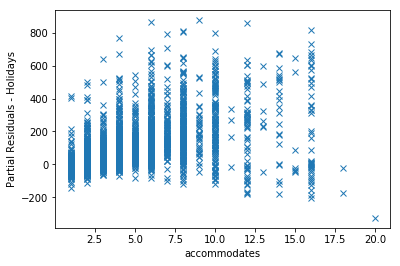

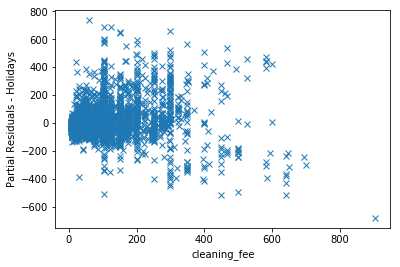

In [116]:
for var,idx in zip(variables,indx):
    partial_residual = residuals_hol + X_hol[var]*linear_regression_hol.coef_[idx]
    plt.plot(X_hol[var], partial_residual, 'x')
    plt.xlabel(var)
    plt.ylabel('Partial Residuals - Holidays')
    plt.show()

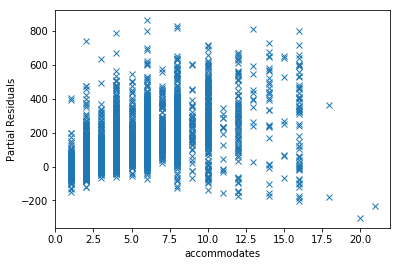

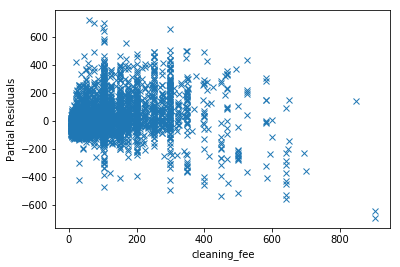

In [117]:
for var,idx in zip(variables,indx):
    partial_residual = residuals_wke + X_wke[var]*linear_regression_wke.coef_[idx]
    plt.plot(X_wke[var], partial_residual, 'x')
    plt.xlabel(var)
    plt.ylabel('Partial Residuals')
    plt.show()

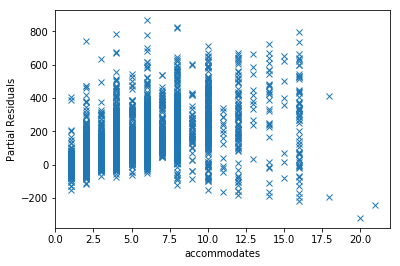

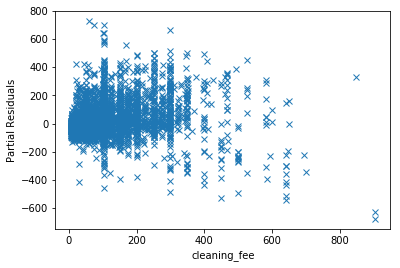

In [118]:
for var,idx in zip(variables,indx):
    partial_residual = residuals_wkd + X_wkd[var]*linear_regression_wkd.coef_[idx]
    plt.plot(X_wkd[var], partial_residual, 'x')
    plt.xlabel(var)
    plt.ylabel('Partial Residuals')
    plt.show()

Plotting Quadratic Regression Residuals

In [121]:
X_hol_t = X_hol.copy()

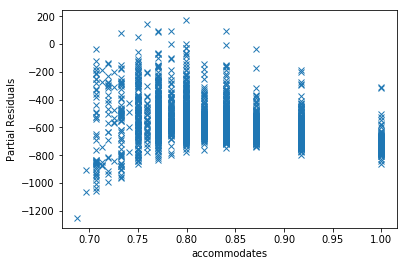

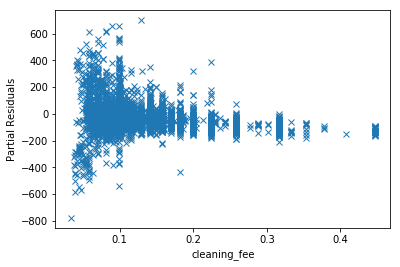

In [124]:
for var,idx in zip(variables,indx):
    X_hol_t[var] = 1/np.sqrt(X_hol_t[var])
    linear_regression.fit(X_hol_t,target_hol)
    partial_residual = residuals_hol + X_hol_t[var]*linear_regression.coef_[idx]
    plt.plot(X_hol_t[var], partial_residual, 'x')
    plt.xlabel(var)
    plt.ylabel('Partial Residuals')
    plt.show()

In [ ]:
#Will need to revisit the above error

Outlier Analysis

In [125]:
from sklearn.neighbors import LocalOutlierFactor

In [128]:
#Using CLF to determine what is an outlier, and give a count

In [129]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_hol)
sm = 0
for i in y_pred:
    if i<0:
        sm=sm+1
sm

400

In [130]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_wke)
sm = 0
for i in y_pred:
    if i<0:
        sm=sm+1
sm

566

In [131]:
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X_wkd)
sm = 0
for i in y_pred:
    if i<0:
        sm=sm+1
sm

576

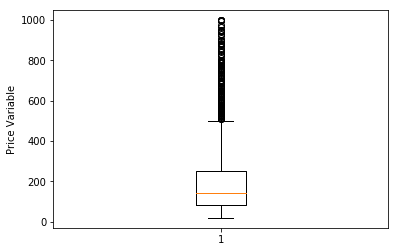

In [132]:
plt.boxplot(target_hol)
plt.ylabel('Price Variable')
plt.show()

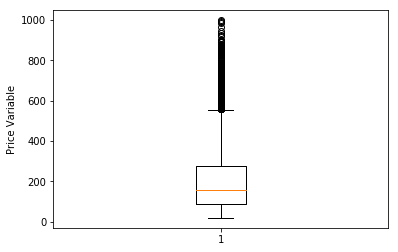

In [133]:
plt.boxplot(target_wke)
plt.ylabel('Price Variable')
plt.show()

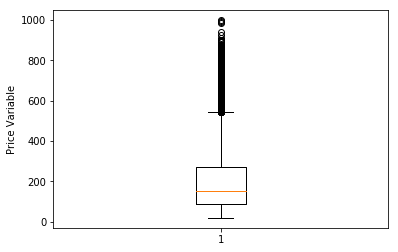

In [134]:
plt.boxplot(target_wkd)
plt.ylabel('Price Variable')
plt.show()

In [136]:
linear_regression.predict(X_hol)

array([-24594.76527113,  -6437.57147944, -16001.34558994, ...,
        -2940.68434538,  -4172.77924474, -20815.93502604])

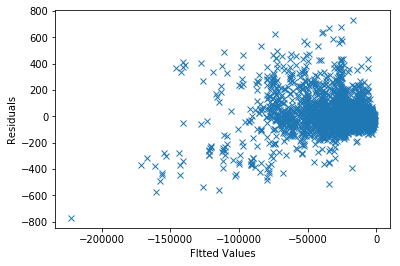

In [137]:
plt.plot(linear_regression.predict(X_hol), residuals_hol, 'x')
plt.ylabel('Residuals')
plt.xlabel('FItted Values')
plt.show()

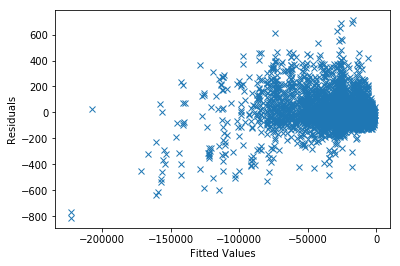

In [140]:
plt.plot(linear_regression.predict(X_wke), residuals_wke, 'x')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.show()

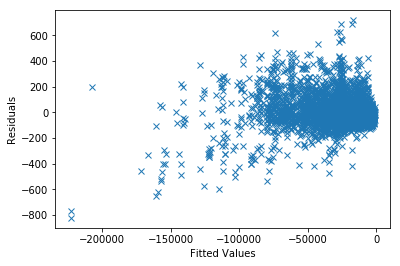

In [142]:
plt.plot(linear_regression.predict(X_wkd), residuals_wkd, 'x')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.show()

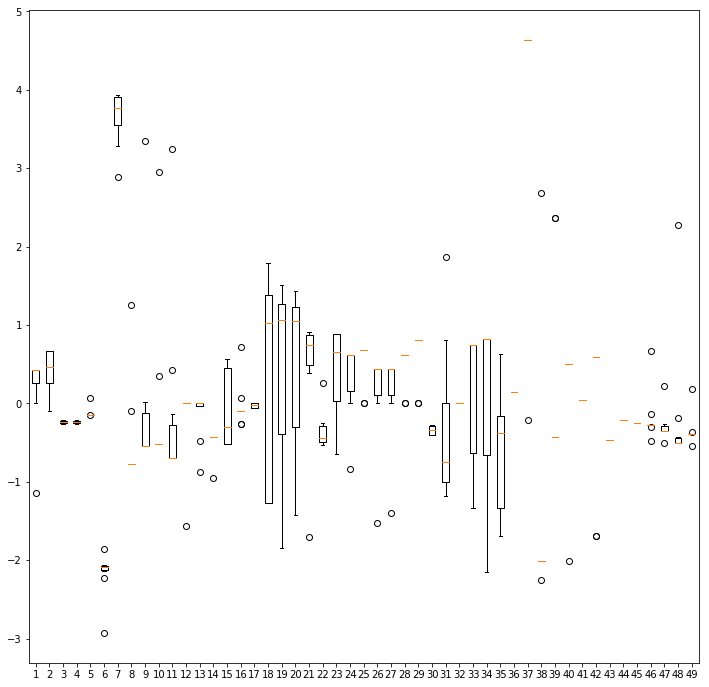

In [143]:
plt.figure(figsize=(12,12))
stand = StandardScaler(with_mean=True, with_std=True)
Xs = standardization.fit_transform(X_hol)
boxplot = plt.boxplot(Xs[0:10])
plt.show()

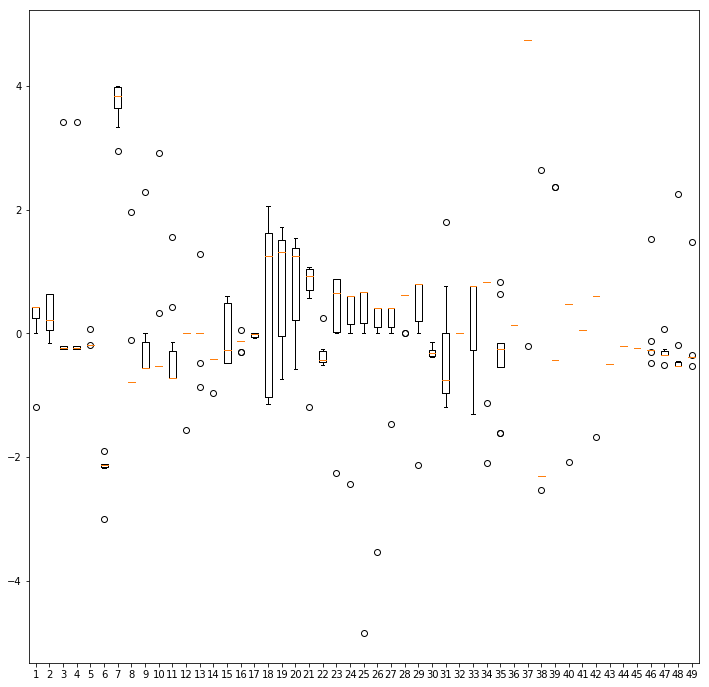

In [145]:
plt.figure(figsize=(12,12))
stand = StandardScaler(with_mean=True, with_std=True)
Xs = standardization.fit_transform(X_wke)
boxplot = plt.boxplot(Xs[0:10])
plt.show()

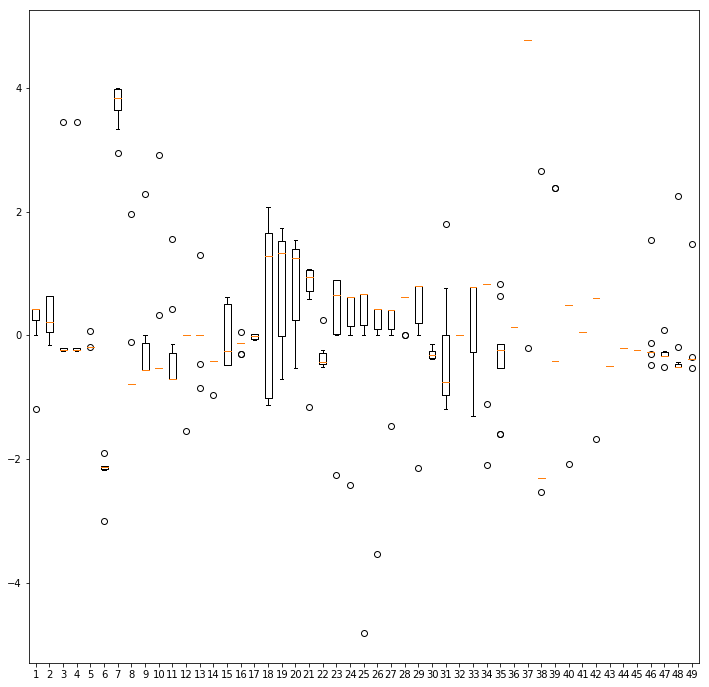

In [146]:
plt.figure(figsize=(12,12))
stand = StandardScaler(with_mean=True, with_std=True)
Xs = standardization.fit_transform(X_wkd)
boxplot = plt.boxplot(Xs[0:10])
plt.show()

PCA on the Holiday Dataset

In [147]:
#Remember to take out certain variables with low p value etc. and then only feed the rest to PCA

In [148]:
from sklearn.decomposition import PCA

In [150]:
pca = PCA()
pca.fit(X_hol)
C = pca.transform(X_hol)
print (pca.explained_variance_ratio_)

[  9.90163607e-01   4.84917261e-03   4.75360430e-03   7.98647539e-05
   5.74960438e-05   4.72057595e-05   3.07701549e-05   6.33322665e-06
   3.69426216e-06   2.29961420e-06   2.02144800e-06   1.33726745e-06
   6.28791125e-07   6.20410004e-07   3.83580573e-07   2.72519804e-07
   1.68532011e-07   1.48498851e-07   1.41384601e-07   8.77997139e-08
   7.19500127e-08   3.50198504e-08   6.50657877e-09   6.10196372e-09
   4.87281326e-09   2.84063394e-09   2.29496391e-09   1.72940193e-09
   1.54655190e-09   1.18061356e-09   1.15015417e-09   9.21533128e-10
   8.02420008e-10   7.32840924e-10   6.70206233e-10   5.99370754e-10
   5.36973222e-10   4.60070538e-10   4.25473288e-10   3.94464255e-10
   3.83022156e-10   3.05130272e-10   1.51949397e-10   3.45841009e-11
   1.63944627e-11   7.42467264e-12   5.83653453e-12   5.27684857e-33
   5.27684857e-33]


In [153]:
exp_var = pca.explained_variance_ratio_

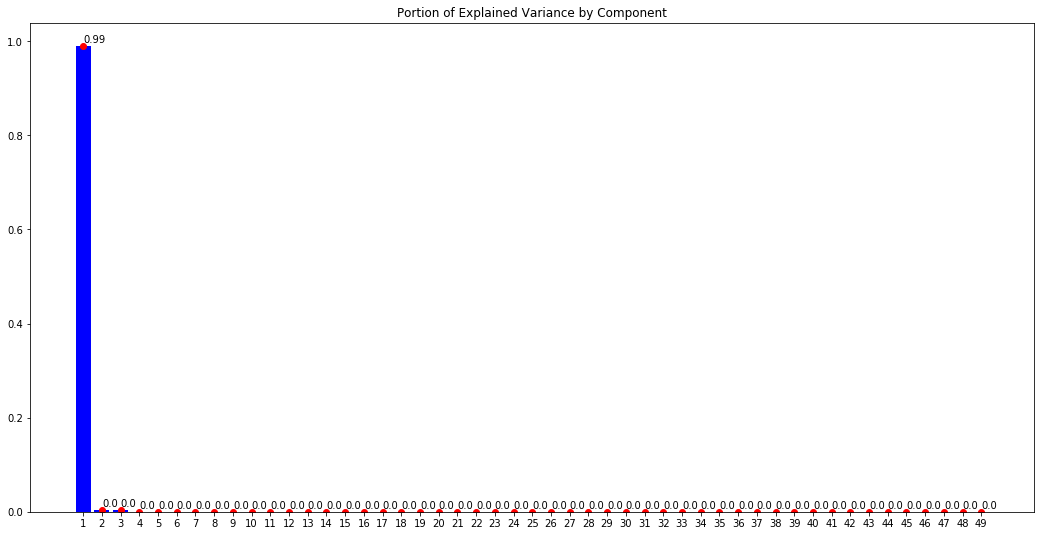

In [154]:
plt.figure(figsize=(18,9))
plt.title('Portion of Explained Variance by Component')
range_ = [r+1 for r in range(len(exp_var))]
plt.bar(range_, exp_var, color='b')
plt.plot(range_, exp_var, 'ro')
for pos, pct in enumerate(exp_var):
    plt.annotate(str(round(pct,2)), (pos+1, pct+0.007))
plt.xticks(range_)
plt.show()

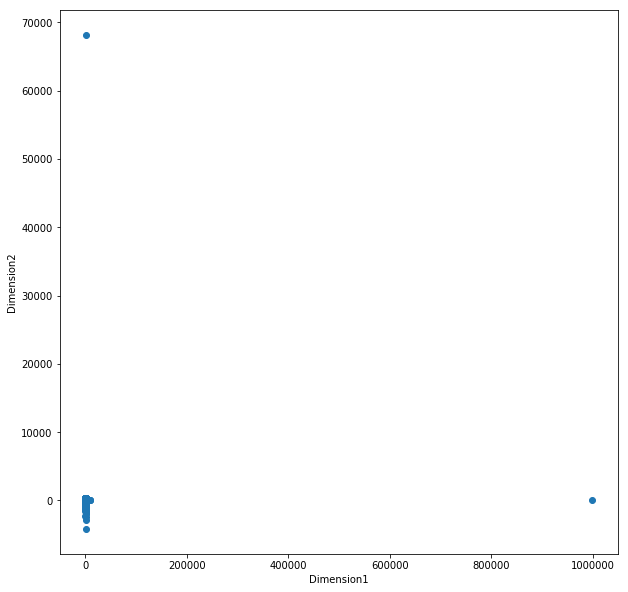

In [156]:
#Plotting the two dimensions, can do the same  for more execpt for fact that all variance seems to be in one?
plt.figure(figsize=(10,10))
plt.scatter(C[:,0], C[:,1])
plt.xlabel('Dimension1')
plt.ylabel('Dimension2')
plt.show()

In [ ]:
#Potentiall remove outliers as a result of this but need to figure out why all variance is explained by one var

This time, trying different polynomial degrees and picking the best R2

In [157]:
from sklearn.metrics import mean_absolute_error

In [166]:
#Already tried degree 3, it overfits and take too long to run so no point in redoing it every time
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, StandardScaler(), linear_regression)
    model = poly.fit(X_hol,target_hol)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_hol, model.predict(X_hol))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_hol, model.predict(X_hol))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, model.predict(X_hol))))
    print("\n")

Model Degree: 1
R2: 0.583
Mean squared error: 11338.27
Mean absolute error: 68.84


Model Degree: 2
R2: 0.806
Mean squared error: 5269.17
Mean absolute error: 49.71




In [167]:
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, StandardScaler(), linear_regression)
    model = poly.fit(X_wke,target_wke)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_wke, model.predict(X_wke))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_wke, model.predict(X_wke))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_wke, model.predict(X_wke))))
    print("\n")

Model Degree: 1
R2: 0.619
Mean squared error: 10313.48
Mean absolute error: 68.20


Model Degree: 2
R2: 0.796
Mean squared error: 5514.98
Mean absolute error: 51.23




In [168]:
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, StandardScaler(), linear_regression)
    model = poly.fit(X_wkd,target_wkd)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_wkd, model.predict(X_wkd))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_wkd, model.predict(X_wkd))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_wkd, model.predict(X_wkd))))
    print("\n")

Model Degree: 1
R2: 0.621
Mean squared error: 9989.53
Mean absolute error: 66.83


Model Degree: 2
R2: 0.796
Mean squared error: 5364.84
Mean absolute error: 50.13




Now try the same as above, only for holiday dataset, but with Mean Centering, MinMaxScaling

In [169]:
#With mean centering
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, StandardScaler(with_mean=True, with_std=False), linear_regression)
    model = poly.fit(X_hol,target_hol)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_hol, model.predict(X_hol))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_hol, model.predict(X_hol))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, model.predict(X_hol))))
    print("\n")

Model Degree: 1
R2: 0.583
Mean squared error: 11338.07
Mean absolute error: 68.84


Model Degree: 2
R2: 0.796
Mean squared error: 5561.05
Mean absolute error: 51.64




In [170]:
from sklearn.preprocessing import MinMaxScaler

In [172]:
#with Normalization
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, MinMaxScaler(), linear_regression)
    model = poly.fit(X_hol,target_hol)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_hol, model.predict(X_hol))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_hol, model.predict(X_hol))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, model.predict(X_hol))))
    print("\n")

Model Degree: 1
R2: 0.583
Mean squared error: 11338.13
Mean absolute error: 68.83


Model Degree: 2
R2: 0.806
Mean squared error: 5269.37
Mean absolute error: 49.73




In [173]:
#with standardization
for d in range(1,3):
    create_poly = PolynomialFeatures(degree=d, interaction_only=False, include_bias=False)
    poly = make_pipeline(create_poly, StandardScaler(with_mean=True, with_std=True), linear_regression)
    model = poly.fit(X_hol,target_hol)
    print ("Model Degree: %i" %(d))
    print ("R2: %0.3f" %(r2_score(target_hol, model.predict(X_hol))))
    print("Mean squared error: %.2f" %(mean_squared_error(target_hol, model.predict(X_hol))))
    print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, model.predict(X_hol))))
    print("\n")

Model Degree: 1
R2: 0.583
Mean squared error: 11338.27
Mean absolute error: 68.84


Model Degree: 2
R2: 0.806
Mean squared error: 5269.17
Mean absolute error: 49.71




In [ ]:
#Evaluating R2 contribution and feature impact for quadratic models

In [174]:
def r2_sq_est(X,y):
    quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    quadratic_predictor = make_pipeline(quad, StandardScaler(with_mean=True, with_std=True),linear_regression)
    return r2_score(y, quadratic_predictor.fit(X,target).predict(X))

In [175]:
r2_impact_hol = list()
baseline_hol = r2_est(X_hol,target_hol)
for j in range(X_hol.shape[1]):
    selection = [i for i in range(X_hol.shape[1]) if i!=j]
    r2_impact_hol.append(((r2_est(X_hol,target_hol)-(r2_est(X_hol.values[:,selection],target_hol)),X_hol.columns[j])))
for imp, var in sorted(r2_impact_hol, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.021 accommodates
 0.014 cleaning_fee
 0.014 longitude
 0.012 bedrooms
 0.008 bathrooms
 0.006 bathrooms*cleaning_fee
 0.003 availability_90
 0.002 bathrooms*addommodates
 0.002 availability_60
 0.001 require_guest_phone_verification
 0.001 host_resp_time_enc
 0.001 policy_enc
 0.001 require_guest_profile_picture
 0.001 minimum_nights
 0.001 security_deposit
 0.001 host_response_rate
 0.001 guests_included
 0.001 availability_30
 0.001 review_scores_cleanliness
 0.000 bathrooms*guests_included
 0.000 host_acceptance_rate
 0.000 review_scores_value
 0.000 accomodates*cleaning_fee
 0.000 review_scores_accuracy
 0.000 jurisdiction_names_enc
 0.000 host_identity_verified
 0.000 beds
 0.000 latitude
 0.000 zipcode_enc
 0.000 number_of_reviews
 0.000 availability_365
 0.000 reviews_per_month
 0.000 is_location_exact
 0.000 review_scores_location
 0.000 host_is_superhost
 0.000 review_scores_communication
 0.000 bed_type_enc
 0.000 instant_bookable
 0.000 review_scores_checkin
 0.000 calcul

In [176]:
r2_impact_wke = list()
baseline_wke = r2_est(X_wke,target_wke)
for j in range(X_wke.shape[1]):
    selection = [i for i in range(X_wke.shape[1]) if i!=j]
    r2_impact_wke.append(((r2_est(X_wke,target_wke)-(r2_est(X_wke.values[:,selection],target_wke)),X_wke.columns[j])))
for imp, var in sorted(r2_impact_wke, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.030 accommodates
 0.016 cleaning_fee
 0.012 longitude
 0.007 bedrooms
 0.007 bathrooms
 0.004 bathrooms*cleaning_fee
 0.004 bathrooms*guests_included
 0.003 availability_90
 0.003 guests_included
 0.003 availability_30
 0.002 security_deposit
 0.002 latitude
 0.002 host_resp_time_enc
 0.002 bathrooms*addommodates
 0.002 beds
 0.001 require_guest_profile_picture
 0.001 require_guest_phone_verification
 0.001 accomodates*cleaning_fee
 0.001 minimum_nights
 0.001 review_scores_cleanliness
 0.001 review_scores_value
 0.001 availability_60
 0.001 policy_enc
 0.001 zipcode_enc
 0.001 review_scores_accuracy
 0.000 number_of_reviews
 0.000 review_scores_location
 0.000 bed_type_enc
 0.000 reviews_per_month
 0.000 host_acceptance_rate
 0.000 host_identity_verified
 0.000 instant_bookable
 0.000 extra_people
 0.000 host_is_superhost
 0.000 is_location_exact
 0.000 host_profile_pic
 0.000 review_scores_checkin
 0.000 availability_365
 0.000 review_scores_communication
 0.000 jurisdiction_names

In [177]:
r2_impact_wkd = list()
baseline_wkd = r2_est(X_wkd,target_wkd)
for j in range(X_wkd.shape[1]):
    selection = [i for i in range(X_wkd.shape[1]) if i!=j]
    r2_impact_wkd.append(((r2_est(X_wkd,target_wkd)-(r2_est(X_wkd.values[:,selection],target_wkd)),X_wkd.columns[j])))
for imp, var in sorted(r2_impact_wkd, reverse=True):
    print("%6.3f %s" %(imp, var))

 0.029 accommodates
 0.015 cleaning_fee
 0.012 longitude
 0.007 bedrooms
 0.007 bathrooms
 0.005 bathrooms*guests_included
 0.004 bathrooms*cleaning_fee
 0.003 guests_included
 0.003 availability_90
 0.003 availability_30
 0.002 host_resp_time_enc
 0.002 security_deposit
 0.002 bathrooms*addommodates
 0.002 latitude
 0.002 beds
 0.001 require_guest_profile_picture
 0.001 require_guest_phone_verification
 0.001 accomodates*cleaning_fee
 0.001 minimum_nights
 0.001 review_scores_cleanliness
 0.001 zipcode_enc
 0.001 review_scores_value
 0.001 review_scores_accuracy
 0.001 availability_60
 0.001 number_of_reviews
 0.001 policy_enc
 0.000 reviews_per_month
 0.000 bed_type_enc
 0.000 host_acceptance_rate
 0.000 host_identity_verified
 0.000 host_is_superhost
 0.000 review_scores_location
 0.000 instant_bookable
 0.000 extra_people
 0.000 is_location_exact
 0.000 availability_365
 0.000 maximum_nights
 0.000 review_scores_communication
 0.000 host_profile_pic
 0.000 jurisdiction_names_enc
 0

Residuals

In [181]:
quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
quadratic_predictor = make_pipeline(quad, StandardScaler(with_mean=True, with_std=True),linear_regression)
quad_model = quadratic_predictor.fit(X_hol,target_hol).predict(X_hol)
residuals = target_hol - quad_model
print("Head of Residual")
print(residuals[:5])
print("Mean of Residuals %0.3f" %np.mean(residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals)))
print("Mean squared error: %.2f" %(mean_squared_error(target_hol, model.predict(X_hol))))
print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, model.predict(X_hol))))
print("R2 Score: %.4f" %(r2_score(target_hol, quad_model)))

Head of Residual
0    -1.220643
1    11.164123
2    92.341430
3   -14.395448
4    16.960998
Name: price_y, dtype: float64
Mean of Residuals 0.178
Standard Deviation of Residuals: 72.589
Mean squared error: 5269.17
Mean absolute error: 49.71
R2 Score: 0.8063


In [184]:
quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
quadratic_predictor = make_pipeline(quad, StandardScaler(with_mean=True, with_std=True),linear_regression)
quad_model = quadratic_predictor.fit(X_wke,target_wke).predict(X_wke)
residuals = target_wke - quad_model
print("Head of Residual")
print(residuals[:5])
print("Mean of Residuals %0.3f" %np.mean(residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals)))
print("Mean squared error: %.2f" %(mean_squared_error(target_wke, model.predict(X_wke))))
print("Mean absolute error: %.2f" %(mean_absolute_error(target_wke, model.predict(X_wke))))
print("R2 Score: %.4f" %(r2_score(target_wke, quad_model)))

Head of Residual
0    -15.091870
1      2.830005
2    127.587818
3     49.447193
4     29.379485
Name: price_y, dtype: float64
Mean of Residuals 0.194
Standard Deviation of Residuals: 74.263
Mean squared error: 17875816093374518854156288.00
Mean absolute error: 1106049232109.03
R2 Score: 0.7965


In [186]:
quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
quadratic_predictor = make_pipeline(quad, StandardScaler(with_mean=True, with_std=True),linear_regression)
quad_model = quadratic_predictor.fit(X_wkd,target_wkd).predict(X_wkd)
residuals = target_wkd - quad_model
print("Head of Residual")
print(residuals[:5])
print("Mean of Residuals %0.3f" %np.mean(residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals)))
print("Mean squared error: %.2f" %(mean_squared_error(target_wkd, model.predict(X_wkd))))
print("Mean absolute error: %.2f" %(mean_absolute_error(target_wkd, model.predict(X_wkd))))
print("R2 Score: %.4f" %(r2_score(target_wkd, quad_model)))

Head of Residual
0   -16.580350
1     7.200900
2    69.646212
3    64.104126
4    34.139284
Name: price_y, dtype: float64
Mean of Residuals 0.065
Standard Deviation of Residuals: 73.245
Mean squared error: 876301365739686329319424.00
Mean absolute error: 494938465769.88
R2 Score: 0.7964


Now Testing a Model for Holiday Data with only top R2 contributors - using Holiday Dataset only

In [188]:
X_hol_ss = X_hol[['accommodates','cleaning_fee','longitude',
                  'bedrooms','bathrooms','bathrooms*cleaning_fee',
                  'availability_90','bathrooms*addommodates',
                  'availability_60','require_guest_phone_verification',
                  'host_resp_time_enc','policy_enc','require_guest_profile_picture',
                  'minimum_nights','security_deposit','host_response_rate','guests_included',
                  'availability_30','review_scores_cleanliness'
                 ]]

In [193]:
quad = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
quadratic_predictor = make_pipeline(quad, StandardScaler(with_mean=True, with_std=True),linear_regression)
quad_model = quadratic_predictor.fit(X_hol_ss,target_hol).predict(X_hol_ss)
residuals = target_hol - quad_model
print("Head of Residual") 
print(residuals[:5])
print("Mean of Residuals %0.3f" %np.mean(residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(residuals)))
print("Mean squared error: %.2f" %(mean_squared_error(target_hol, quad_model)))
print("Mean absolute error: %.2f" %(mean_absolute_error(target_hol, quad_model)))
print("R2 Score: %.4f" %(r2_score(target_hol, quad_model)))

Head of Residual
0   -28.265743
1     5.763609
2    46.194252
3    16.963489
4    17.289572
Name: price_y, dtype: float64
Mean of Residuals -0.000
Standard Deviation of Residuals: 92.986
Mean squared error: 8646.34
Mean absolute error: 60.12
R2 Score: 0.6821


Using these predictors only decrease the R2 from .80 to .68

Now testing the quadratic model on the holiday dataset with cross-validation

In [199]:
#Need to revisit this

In [194]:
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [195]:
def RMSE(y_true, y_pred):
    return np.sum((y_true -y_pred)**2)

In [196]:
lm = LinearRegression()
cv_iterator = KFold(n=len(X_hol), n_folds=10, shuffle=True, random_state=101)

edges = np.histogram(target_hol, bins=10)[1]
binning = np.digitize(target_hol, edges)
stratified_cv_iterator = StratifiedKFold(binning, n_folds=10, shuffle=True, random_state=101)

second_order=PolynomialFeatures(degree=2, interaction_only=False)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [197]:
over_param_X = second_order.fit_transform(X_hol)
cv_score = cross_val_score(lm, over_param_X, target_hol, cv=cv_iterator, scoring='mean_squared_error', n_jobs=1)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

In [198]:
print ('Cv score: Mean: %0.3f Standard Deviation: %0.3f' % (np.mean(np.abs(cv_score)), np.std(cv_score)))

Cv score: Mean: 4727689137.735 Standard Deviation: 14164281593.223


Univariate feature selection approach could be done but not good if there is collinearity

Multivariate Approach for Feature Selection on Holidays

In [ ]:
#Recursive Selector Takes Way too Long - Doing GridSearchCV instead

In [200]:
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X_hol,target_hol, test_size=.30, random_state=1)

In [202]:
lm = LinearRegression()
second_order=PolynomialFeatures(degree=2, interaction_only=False)

In [203]:
cv_iterator = KFold(n=len(X_train), n_folds=10, shuffle=True, random_state=101)

In [204]:
recursive_selector = RFECV(estimator=lm, step=1, cv=cv_iterator, scoring='mean_squared_error')
recursive_selector.fit(second_order.fit_transform(X_train), y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0

KeyboardInterrupt: 

In [ ]:
print ('Initial number of features : %i' % 
       second_order.fit_transform(X_train).shape[1])
print ('Optimal number of features : %i' % 
       recursive_selector.n_features_)

In [ ]:
#GridSearch CV
#parameters for nonlinear regression: degree, interaction_onlu, include_bias

In [205]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0, normalize=True, max_iter=10**5)

In [206]:
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import expon

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [207]:
lm = LinearRegression()
second_order=PolynomialFeatures()

In [215]:
np.random.seed(101)
search_func=RandomizedSearchCV(
    estimator=lasso, n_jobs=1, iid=False, refit=True, n_iter=15,
    param_distributions={'alpha':np.logspace(-5,2,100)}, 
    scoring='mean_squared_error', cv=stratified_cv_iterator)

In [216]:
search_func.fit(second_order.fit_transform(X_hol), target_hol)
print ('Best degree: %0.5f' % search_func.best_params_['alpha'])
print ('Best CV mean absolute error: %0.3f' % np.abs(search_func.best_score_))

KeyboardInterrupt: 

In [225]:
#Exporting the datasets so they can be used by other nb
X_hol.to_parquet('Datasources/X_hol.parquet', engine='fastparquet')
pd.DataFrame(target_hol).to_parquet('Datasources/target_hol.parquet', engine='fastparquet')
X_wke.to_parquet('Datasources/X_wke.parquet', engine='fastparquet')
pd.DataFrame(target_wke).to_parquet('Datasources/target_wke.parquet', engine='fastparquet')
X_wkd.to_parquet('Datasources/X_wkd.parquet', engine='fastparquet')
pd.DataFrame(target_wkd).to_parquet('Datasources/target_wkd.parquet', engine='fastparquet')